In [1]:
%pip install svgwrite

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.1.7/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import svgwrite

In [3]:
from math import inf
class Piece:
    def __init__(self, rep:str):
        self.arr = []

        srows = rep.split('\n')
        self._height = len(srows)
        self._width = len(srows[0])
        self._ceil = [-1] * self._width
        self._floor = [inf] * self._width
        for i, line in enumerate(reversed(srows)):
            row = [True if ch == '*' else False for ch in line]
            for j, col in enumerate(row):
                if col:
                    self._ceil[j] = i
                    self._floor[j] = min(self._floor[j], i)
            self.arr.append(row)

    @property
    def height(self) -> int:
        return self._height

    @property
    def num_cols(self) -> int:
        return len(self.arr[0])

    @property
    def toarray(self) -> [[bool]]:
        return self.arr

    def ceil(self, col:int) -> int:
        return self._ceil[col]

    def floor(self, col:int) -> int:
        return self._floor[col]

    def _repr_svg_(self) -> str:
        side_len = 10
        dwg = svgwrite.Drawing()
        dwg.viewbox(0,0,800,50)

        for row in range(len(self.arr)):
            for col in range(len(self.arr[0])):
                left_top = (col*side_len, (self._height-row)*side_len)
                width_height = (side_len, side_len)
                fill = 'blue' if self.arr[row][col] else 'black'
                dwg.add(dwg.rect(left_top, width_height, fill=fill))
        return dwg.tostring()

In [4]:
z = Piece("**-\n-**")

In [5]:
z.ceil(1)

1

In [6]:
z.height

2

In [7]:
import os

class PieceLoader:
    def load(self, directory:str) -> None:
        self._pieces = {}
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f):
                with open(f, 'r') as inf:
                    data = inf.read()
                    self._pieces[filename] = Piece(data)
    @property
    def pieces(self):
        return self._pieces

    def __init__(self, directory:str = "data/"):
        self.load(directory)

In [8]:
ldr = PieceLoader()

i


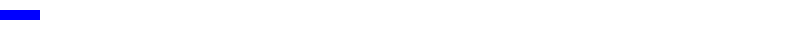

z


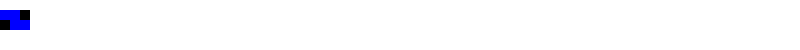

t


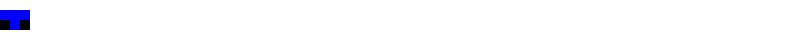

s


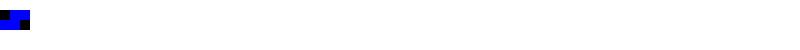

j


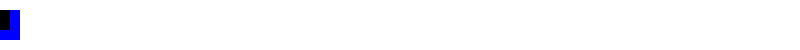

q


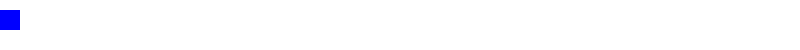

l


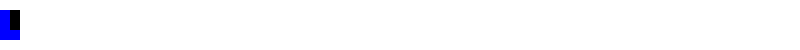

In [9]:
from IPython.display import SVG, display

    
for name, piece in ldr.pieces.items():
    print(name)
    display(SVG(piece._repr_svg_()))


In [10]:
from math import inf
class Playfield:
    def __init__(self, rows:int = 20, cols:int = 10):
        self._rows = rows
        self._cols = cols
        self._playfield = [[None] * cols for _ in range(rows)]
        self._column_height = [-1] * cols
    @property
    def col_height(self):
        return self._column_height
        
    @property
    def height(self) -> int:
        return max(height+1 for height in self._column_height)

    def add(self, piece:Piece, col:int) -> int:
        "Add the given piece to the playfield. It settles at the highest point of first contact."
        
        # Determine the row of the playfield where the bottom row of the piece
        # will land. If there are no populated blocks on the playfield then the
        # default landing row is the bottom of the playfield (row 0). Otherwise
        # it is the highest point of collision.
        resting_row = 0

        for i in range(piece.num_cols):
            if self._column_height[col+i] < 0:
                resting_row = max(resting_row, 0)
                continue

            #print(f'{i}: self._column_height[col+i]: {self._column_height[col+i]} piece.floor({i}): {piece.floor(i)}')
            collision_height = (self._column_height[col+i] + 1) - piece.floor(i)
            resting_row = max(resting_row, collision_height)
            #print(f'col_height: {collision_height} resting_row: {resting_row}')
        #print('resting_row:', resting_row)
        A = piece.toarray
        
        for i, prow in enumerate(A):
            for j, pcol in enumerate(prow):
                if pcol:
                    self._playfield[resting_row+i][col+j] = True
                    self._column_height[col+j] = resting_row + piece.ceil(j)
        #print(self._column_height)
        return resting_row

    def clear(self, bottom_row:int, num_rows: int) -> int:
        "Clears any full rows, adjusting column heights. Returns number of cleared rows."
        top_row = bottom_row + num_rows
        cur_row = bottom_row
        cleared_lines = 0
        while cur_row < top_row:
            if all(self._playfield[cur_row]):
                del self._playfield[cur_row]
                self._rows -= 1
                top_row -= 1
                cleared_lines += 1
                self._column_height = [height-1 for height in self._column_height]
            else:
                cur_row += 1
        return cleared_lines
            
    def add_with_clear(self, piece:Piece, col:int) -> int:
        "Adds a piece at [col] and potentially clears any effected rows."
        resting_row = self.add(piece, col)
        return self.clear(resting_row, piece.height)

    def _repr_svg_(self) -> str:
        side_len = 10
        dwg = svgwrite.Drawing()
        dwg.viewbox(0,0,800,450)

        for row in range(self._rows):
            for col in range(self._cols):
                left_top = (col*side_len, (self._rows-row)*side_len)
                width_height = (side_len, side_len)
                fill = 'black' if not self._playfield[row][col] else 'blue'
                dwg.add(dwg.rect(left_top, width_height, stroke='white', fill=fill))
        return dwg.tostring()

In [12]:
def process(line:str) -> Playfield:
    pf = Playfield()
    for instr in line.split(','):
        shape, col = instr[0].lower(), int(instr[1])
        cleared_lines = pf.add_with_clear(ldr.pieces[shape], col)
        display(pf)
        #print(f'cleared {cleared_lines} lines')
    return pf    

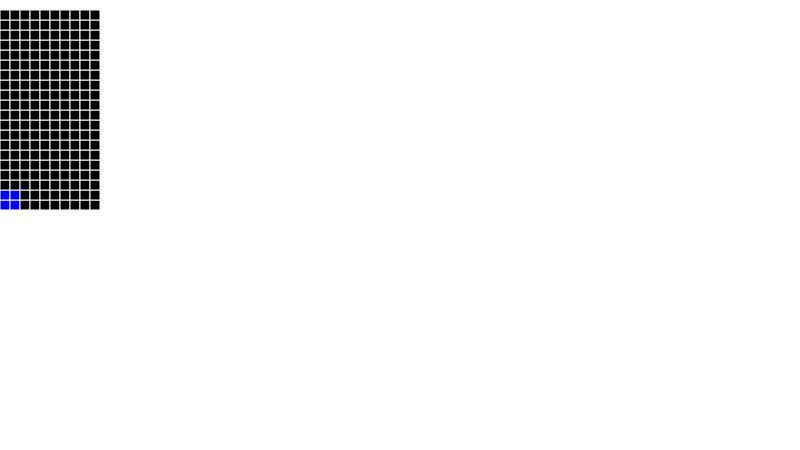

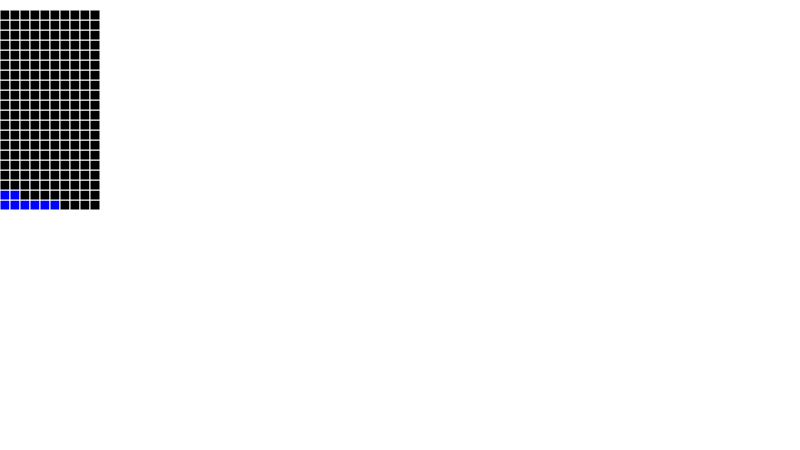

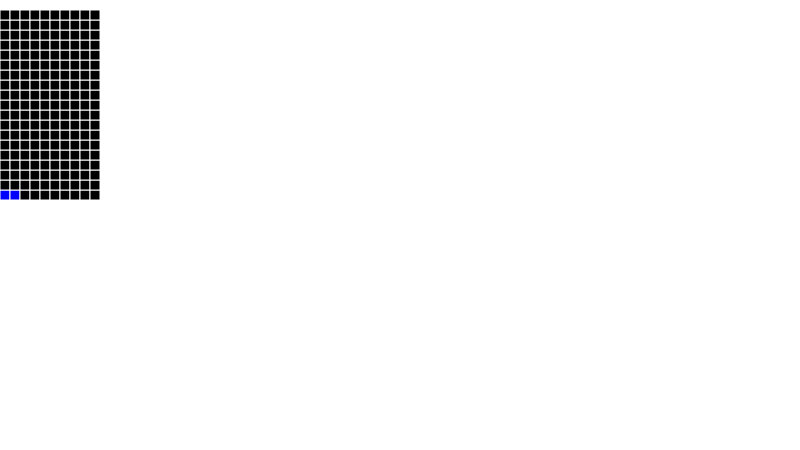

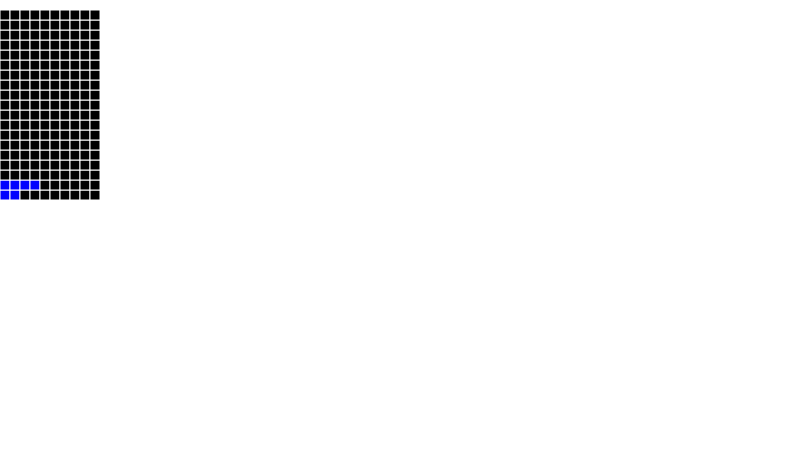

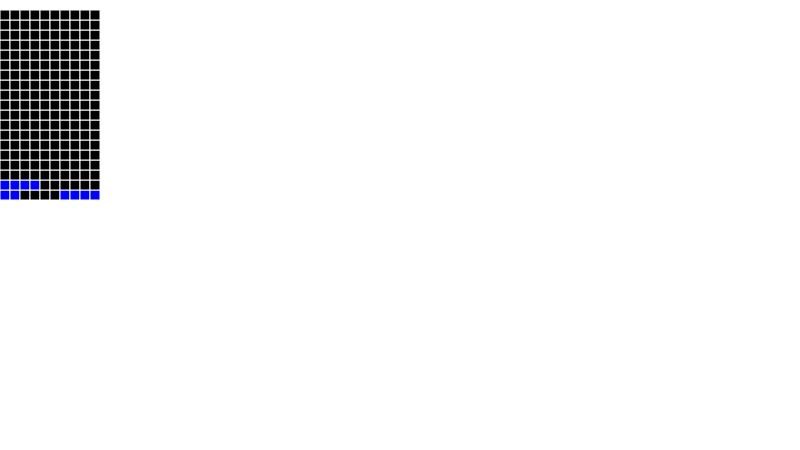

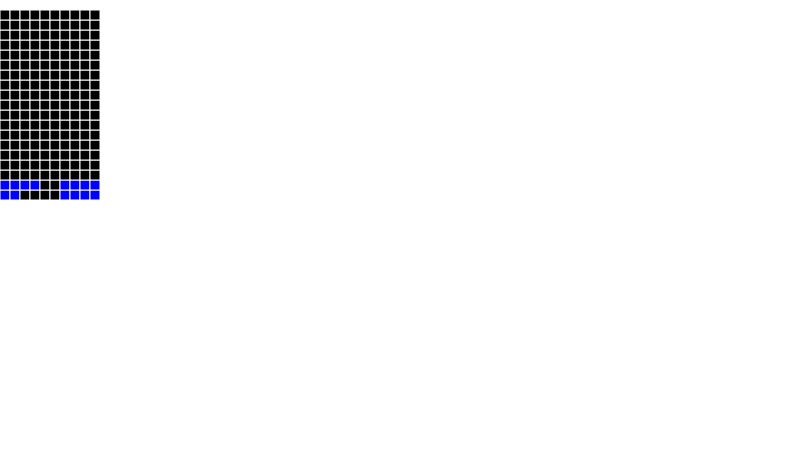

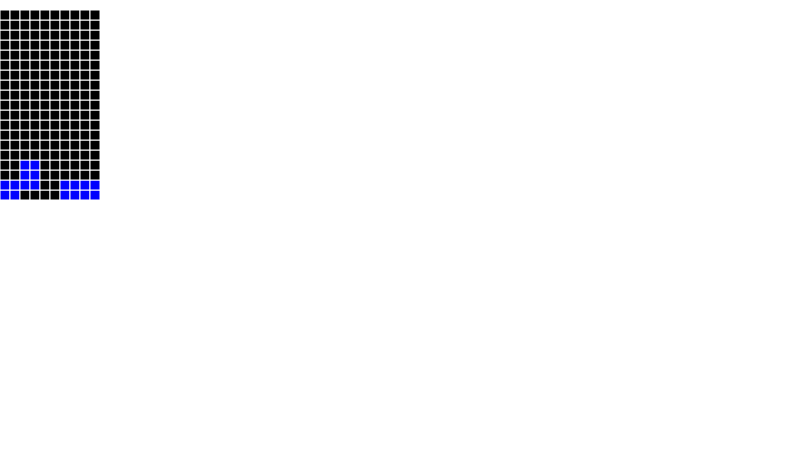

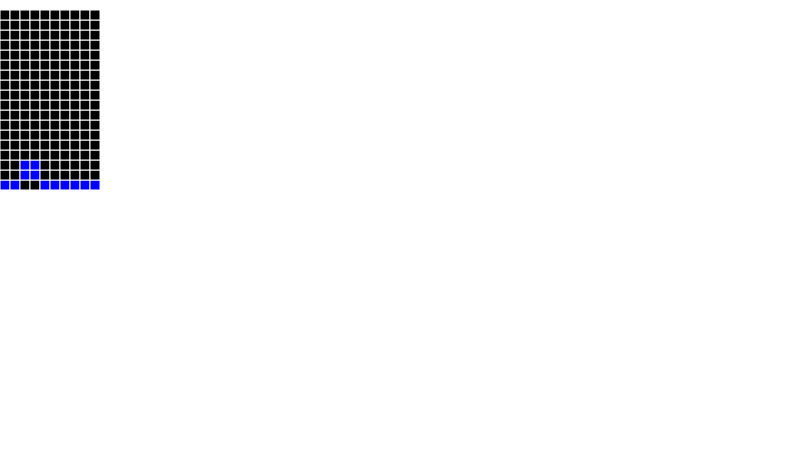

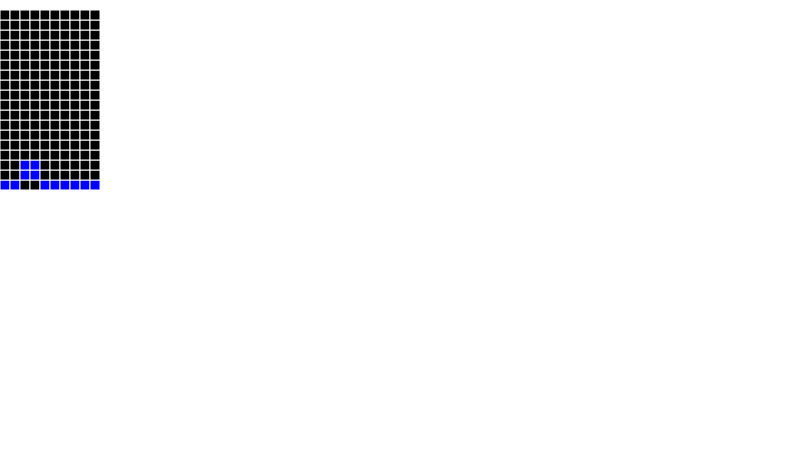

In [13]:
pf = process('Q0,I2,I6,I0,I6,I6,Q2,Q4')
pf


In [14]:
pf.height

3

In [15]:
pf.add(ldr.pieces['z'], 0)

3

In [16]:
pf.col_height

[4, 4, 3, 2, 0, 0, 0, 0, 0, 0]

In [17]:
ldr.pieces['t'].floor(0)

1

In [18]:
pf.add(ldr.pieces['t'], 2)
#pf.add(ldr.pieces['z'], 7)

3

In [19]:
pf = Playfield()
pf.add(ldr.pieces['z'], 0)
pf.add(ldr.pieces['t'], 2)
pf.height == 2

True

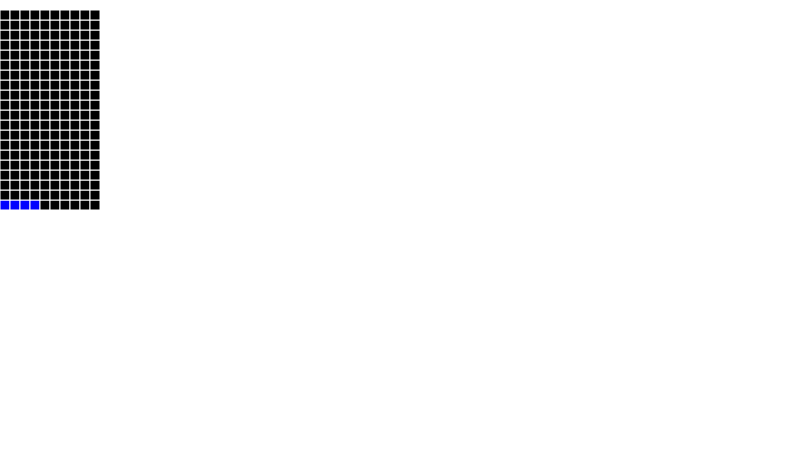

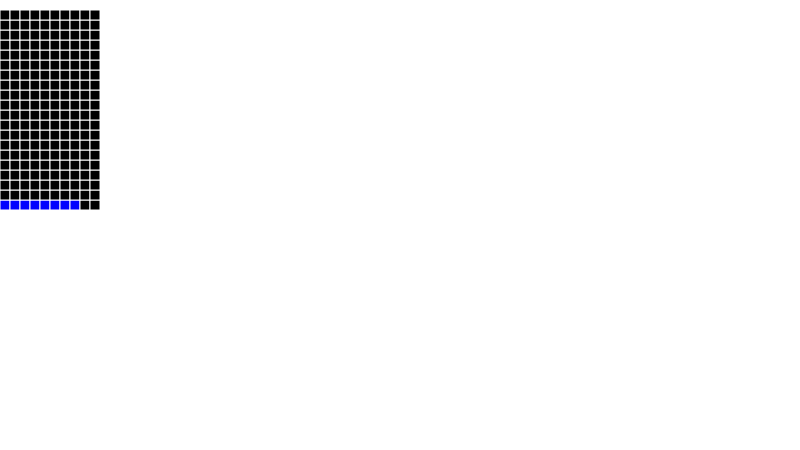

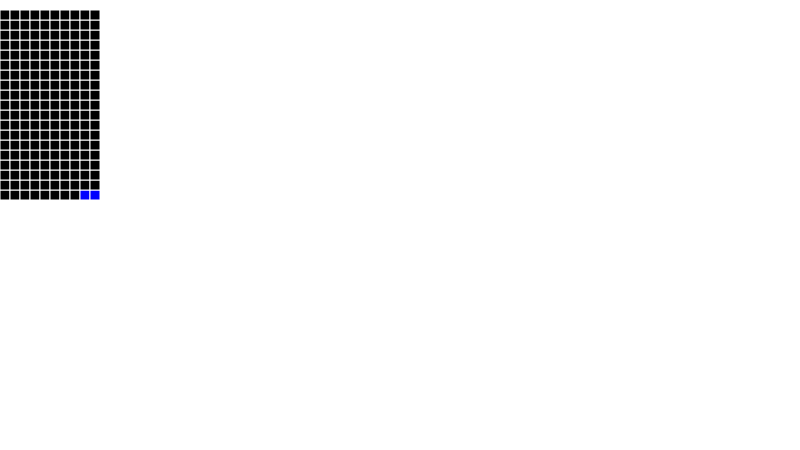

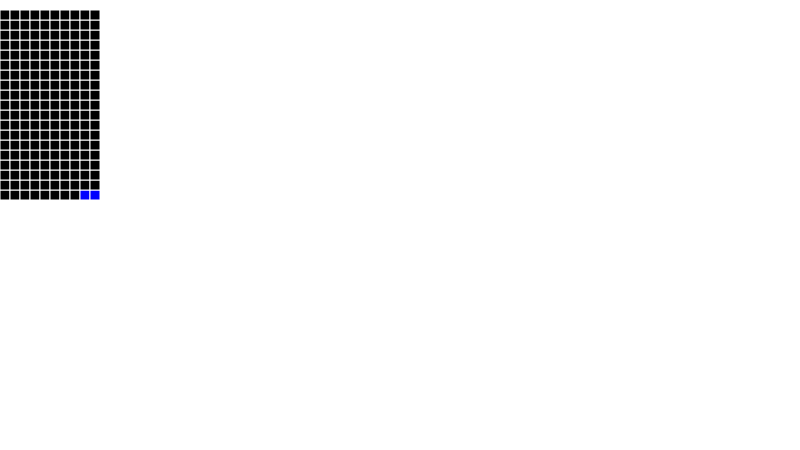

In [20]:
process('I0,I4,Q8')

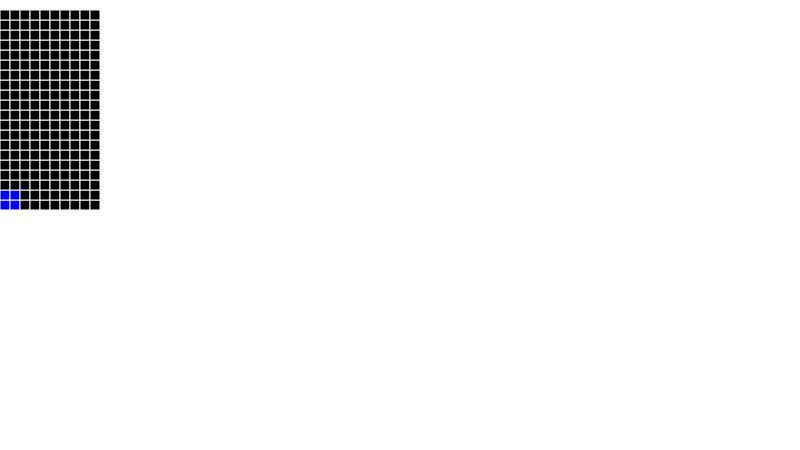

2


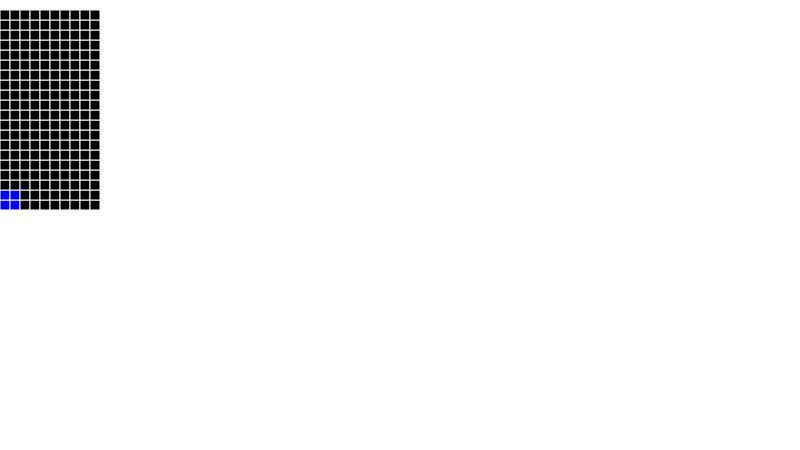

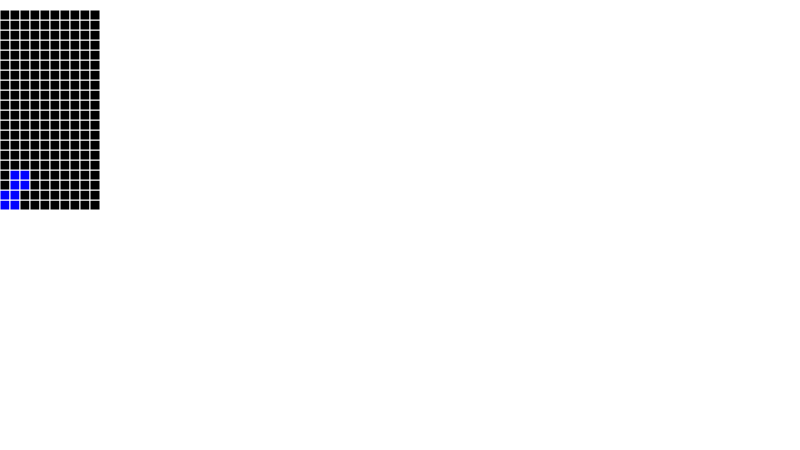

4


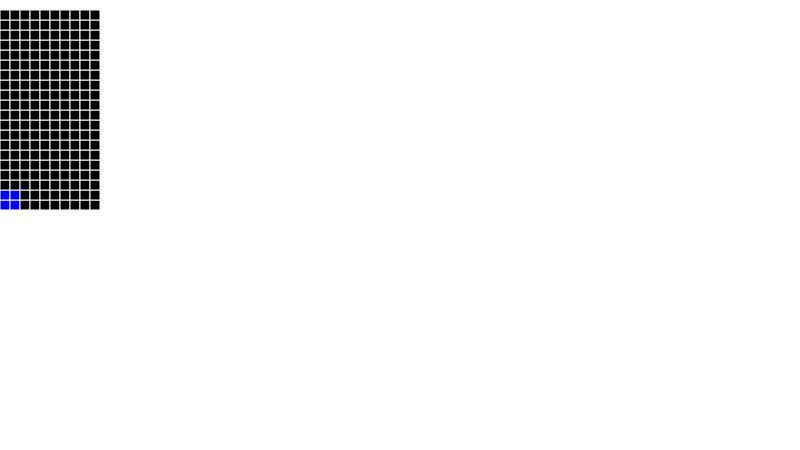

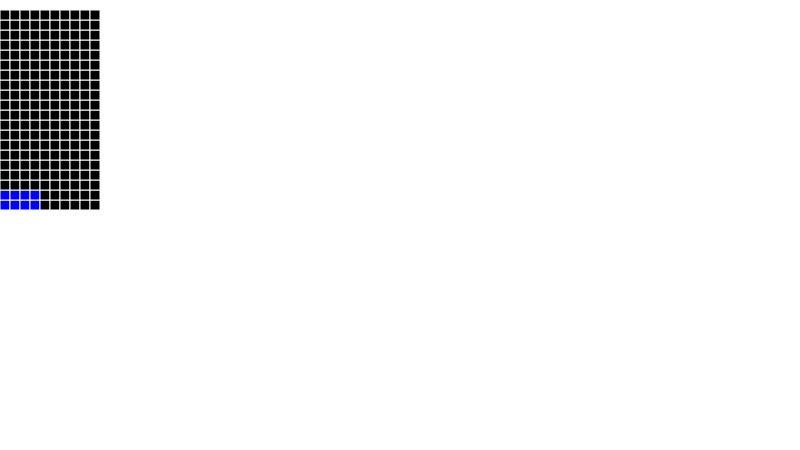

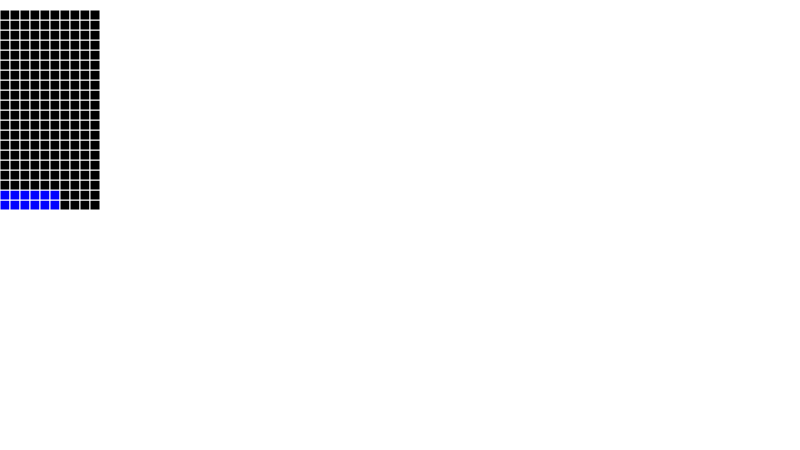

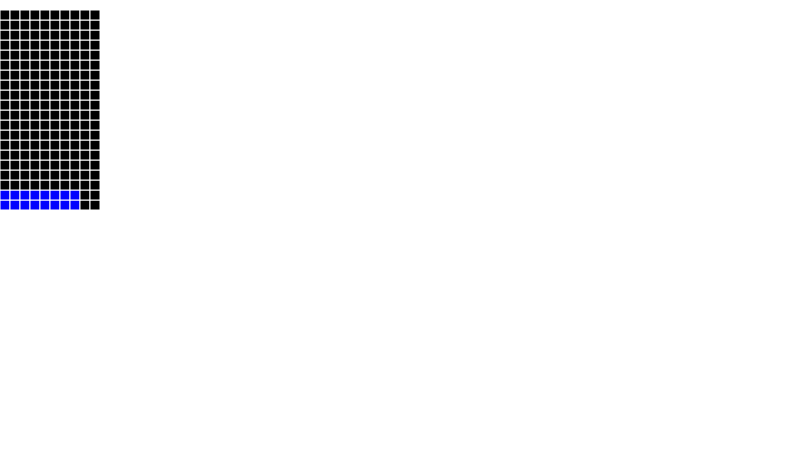

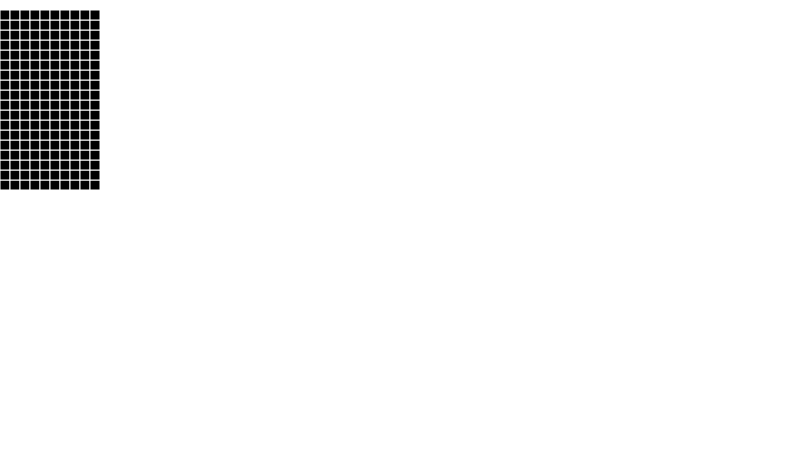

0


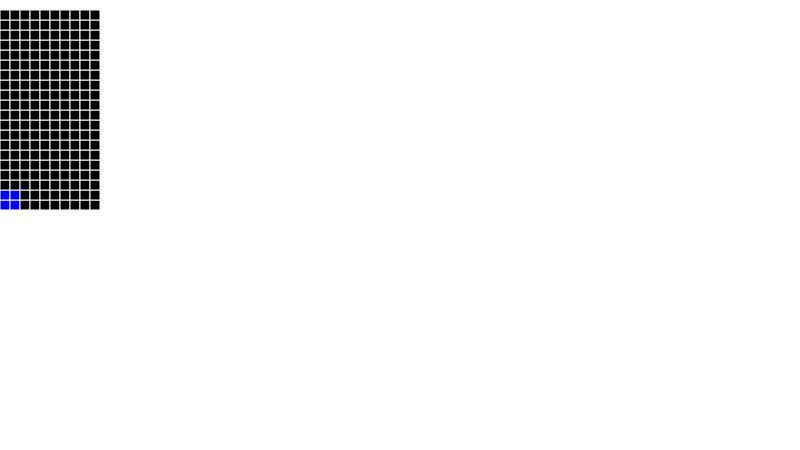

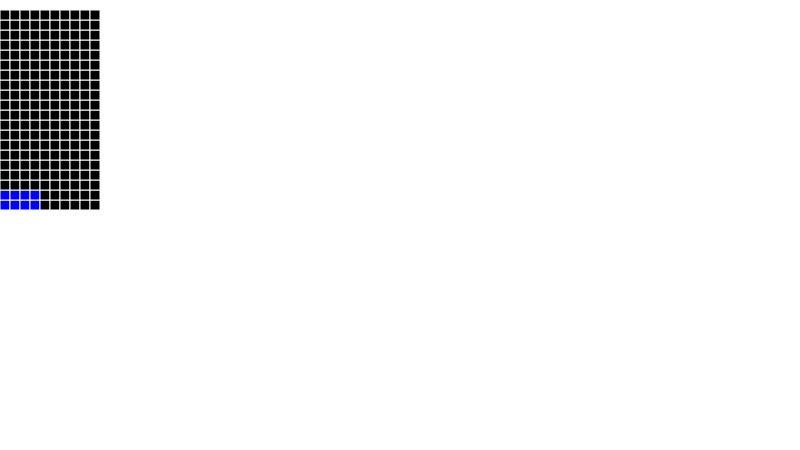

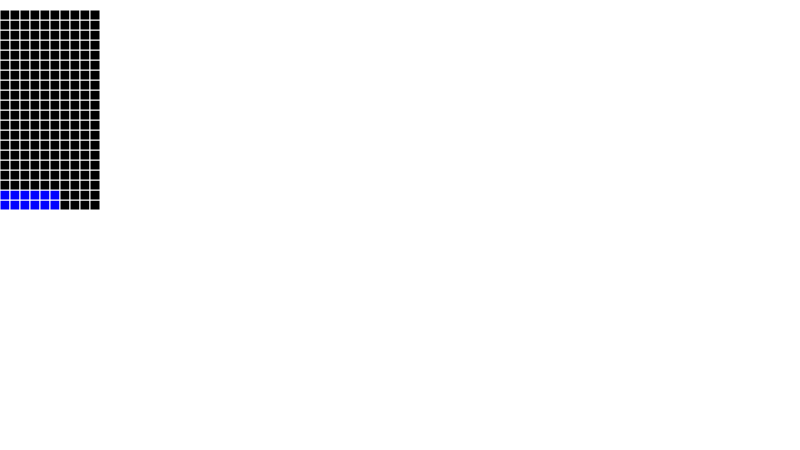

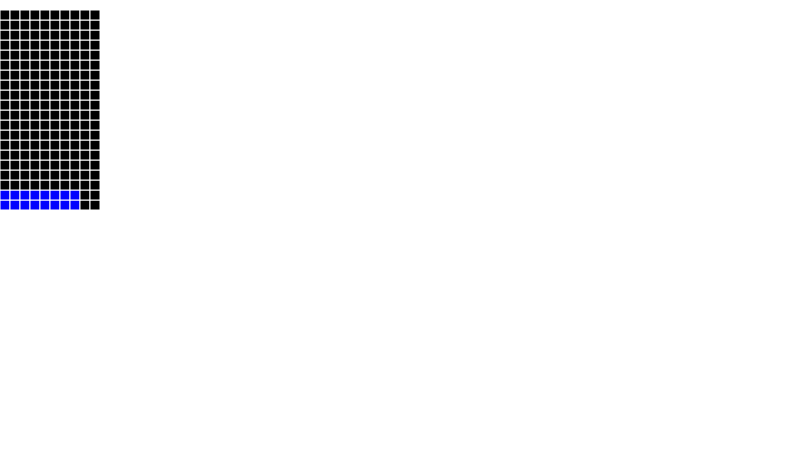

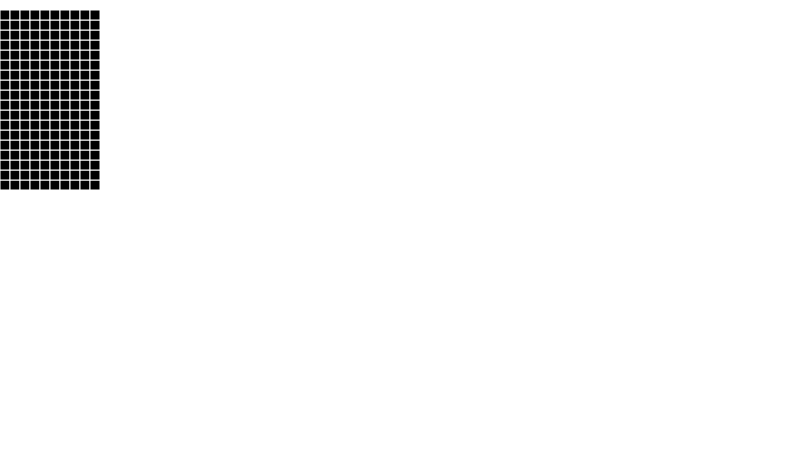

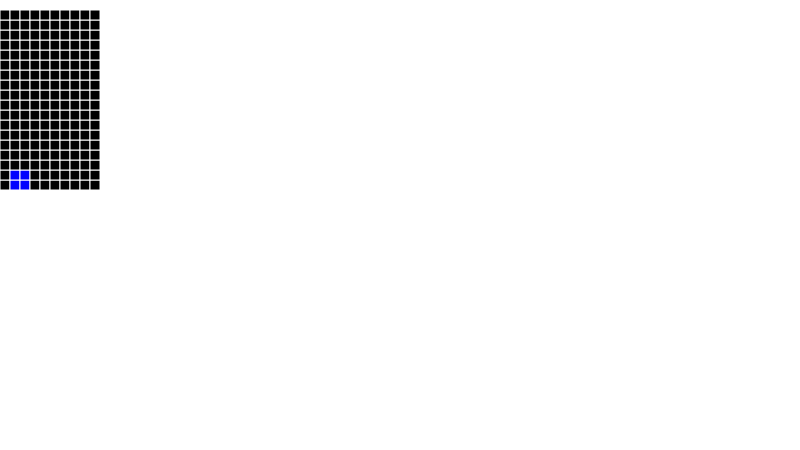

2


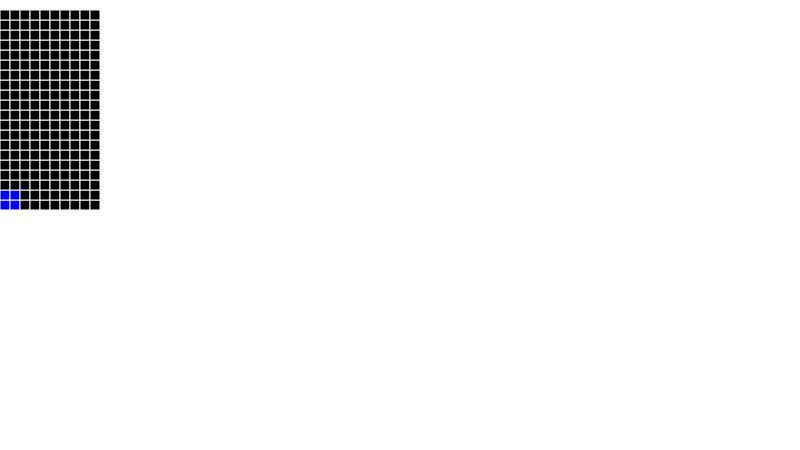

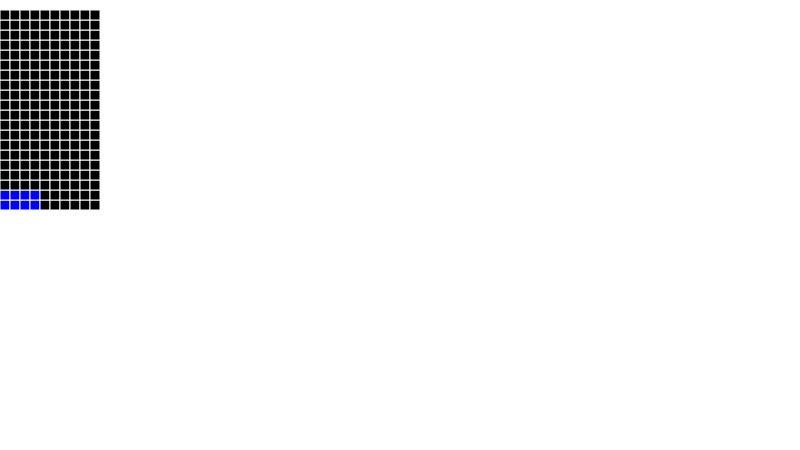

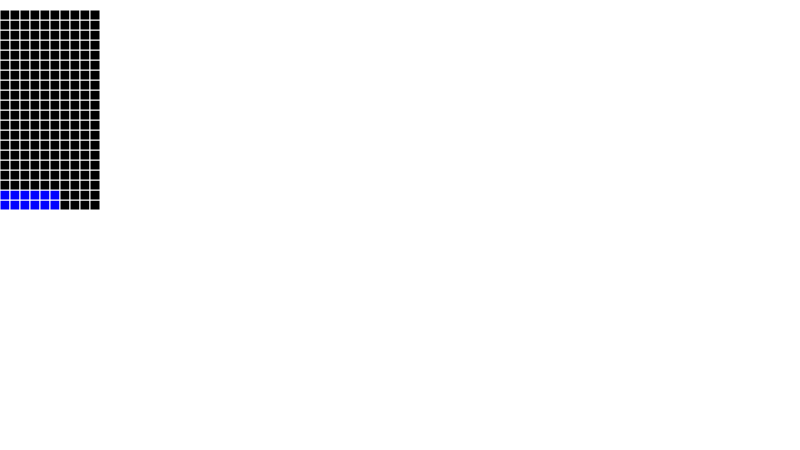

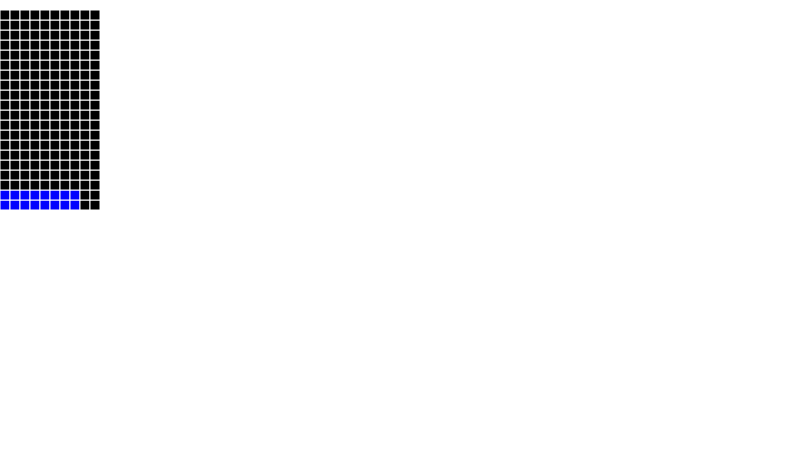

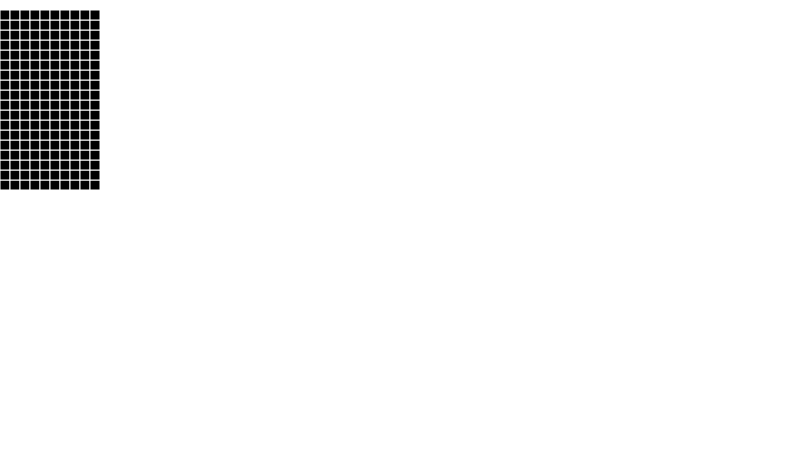

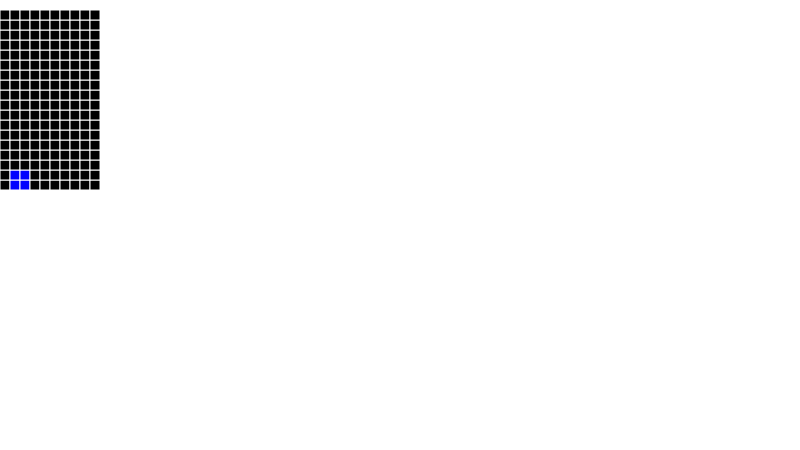

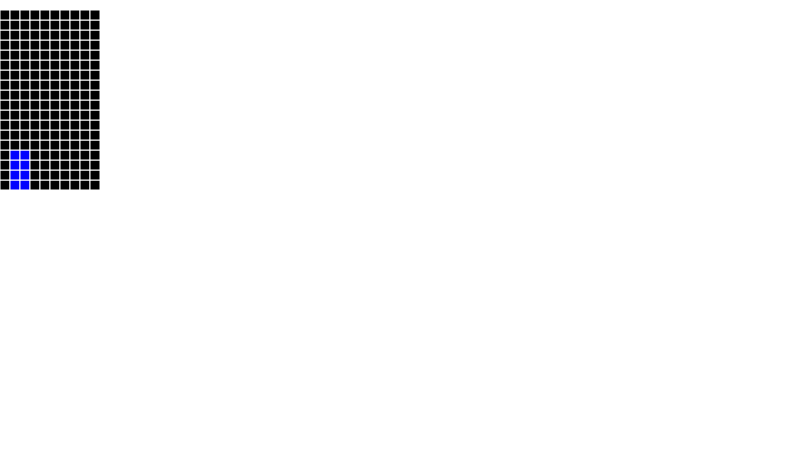

4


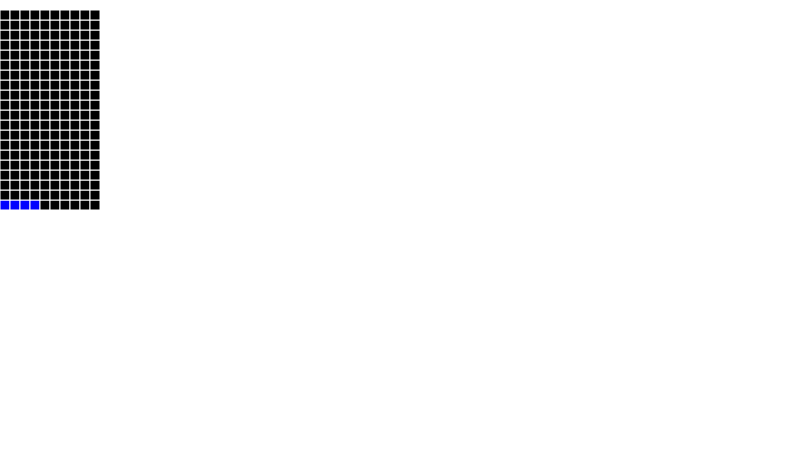

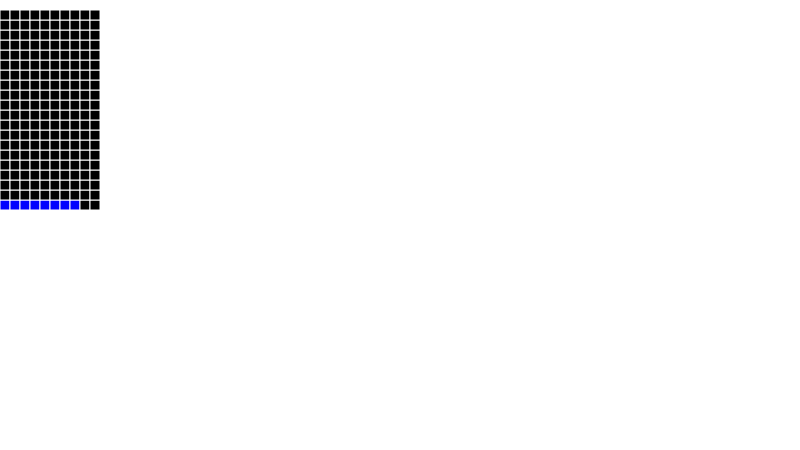

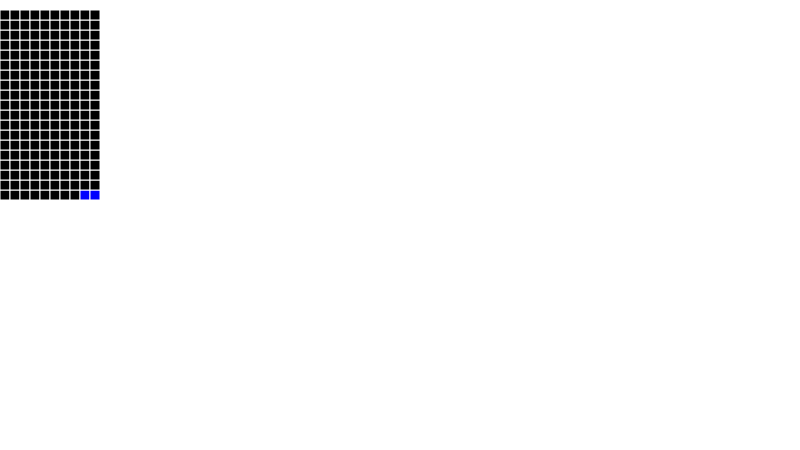

1


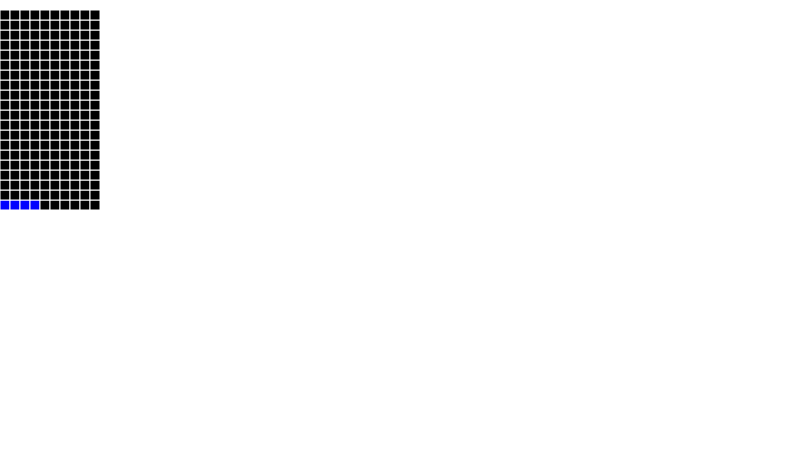

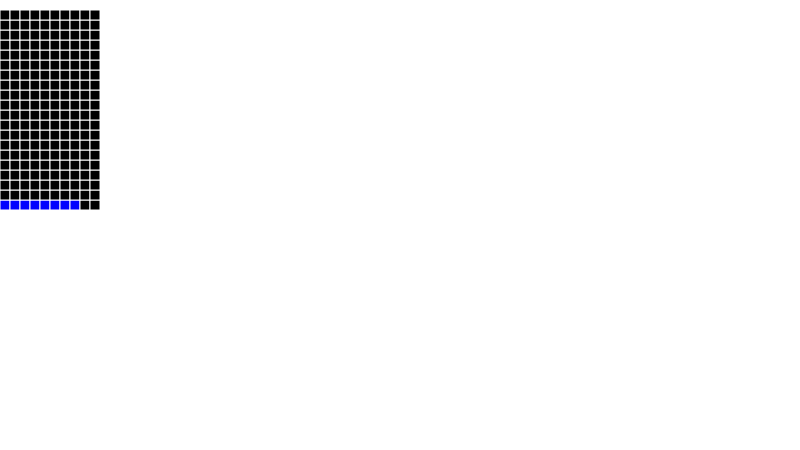

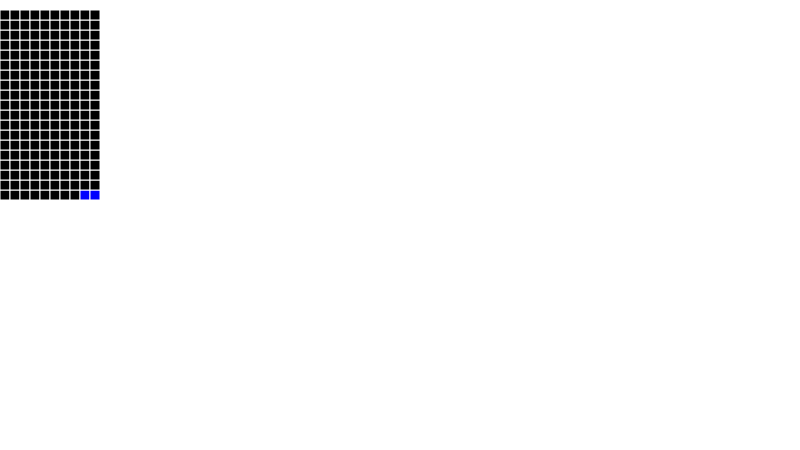

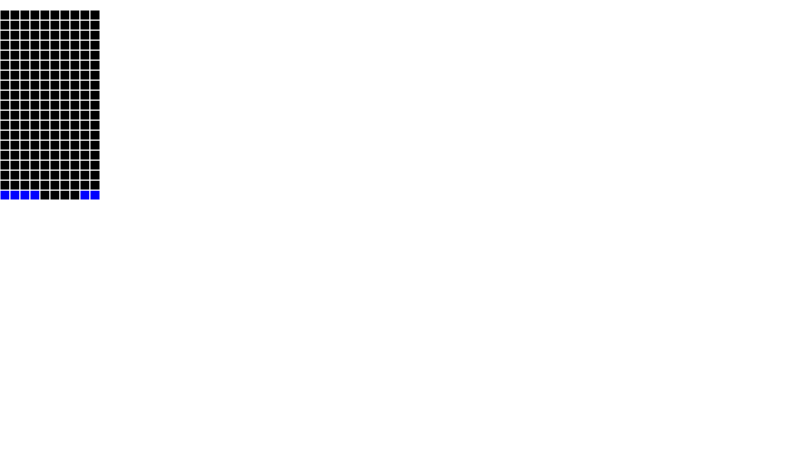

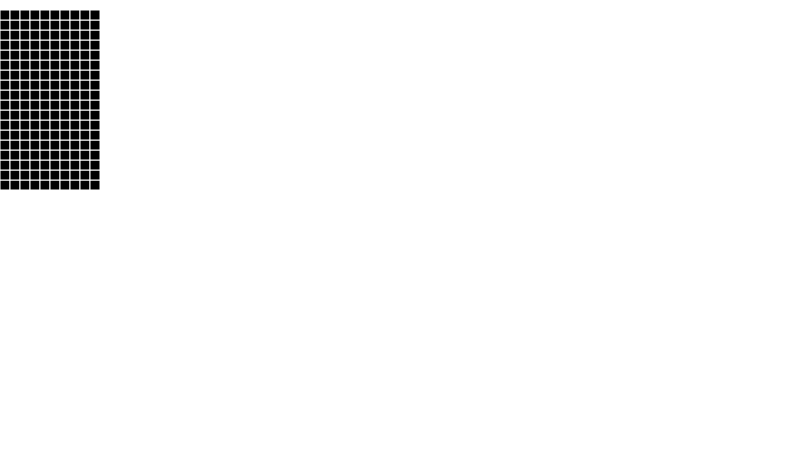

0


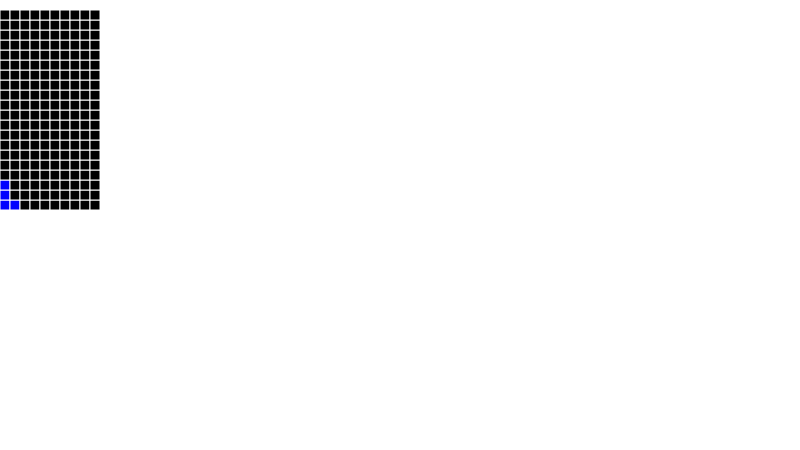

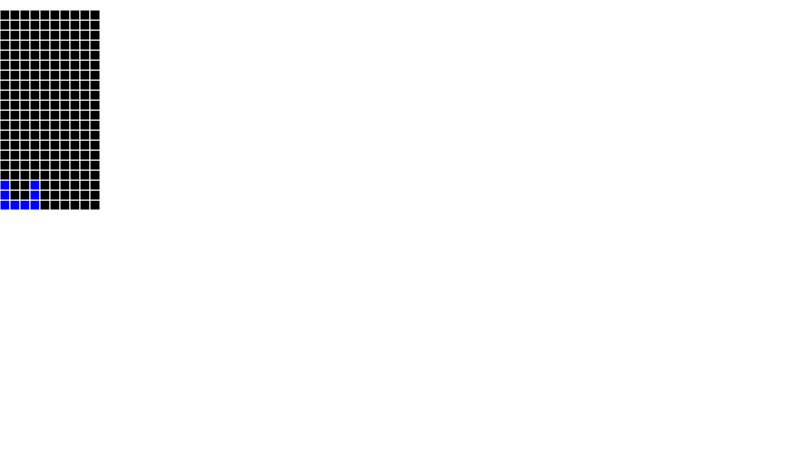

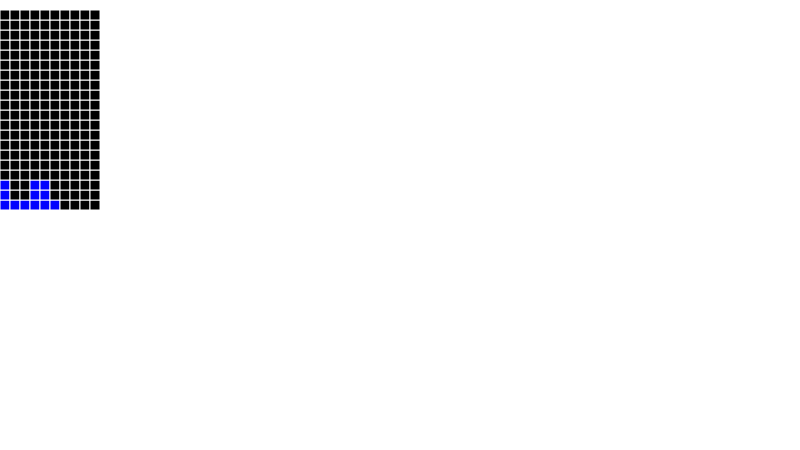

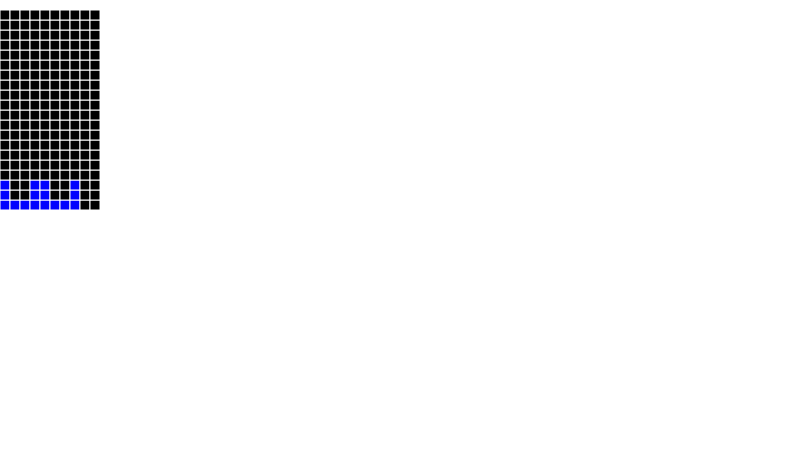

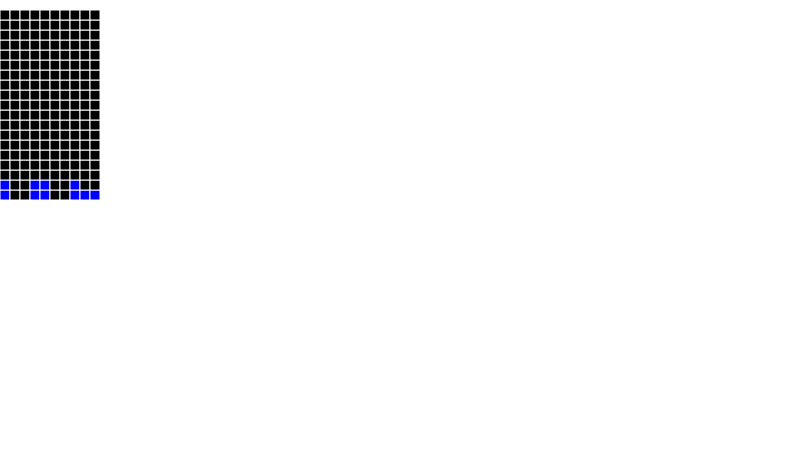

2


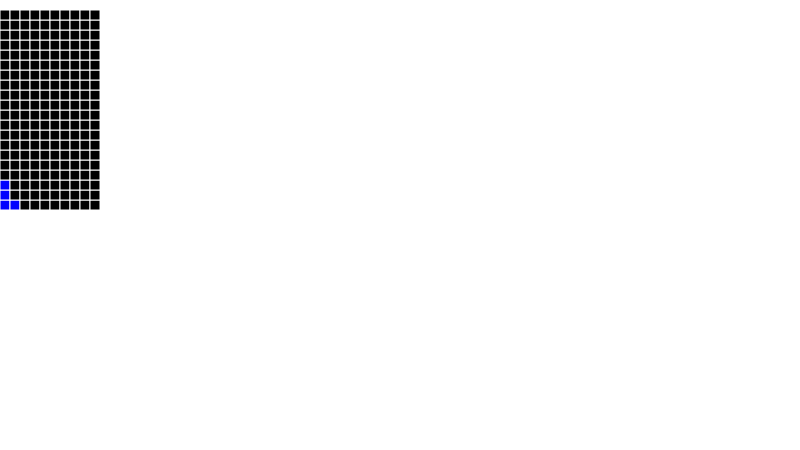

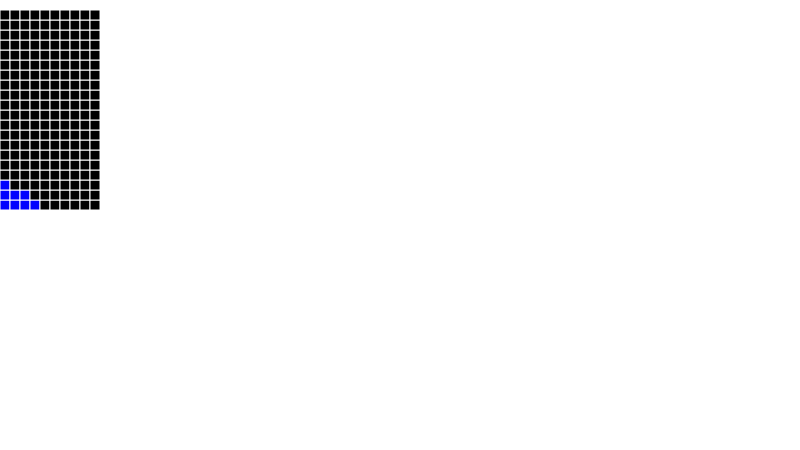

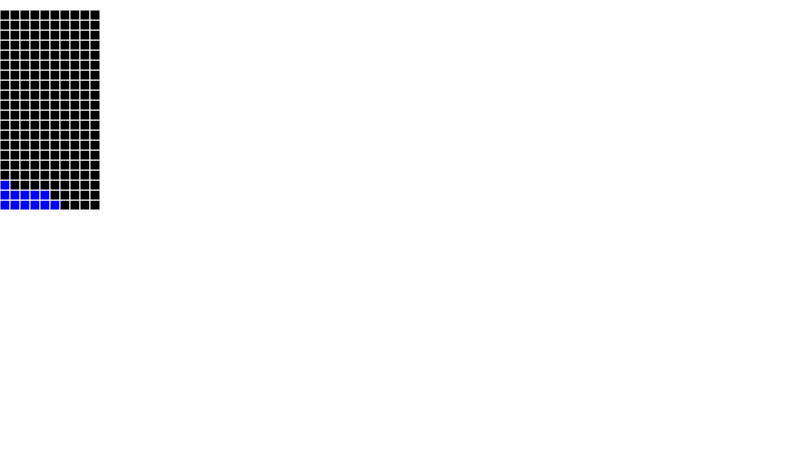

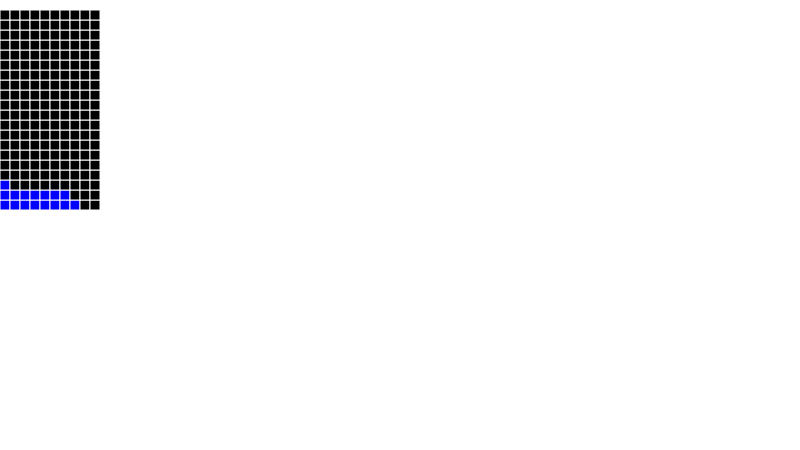

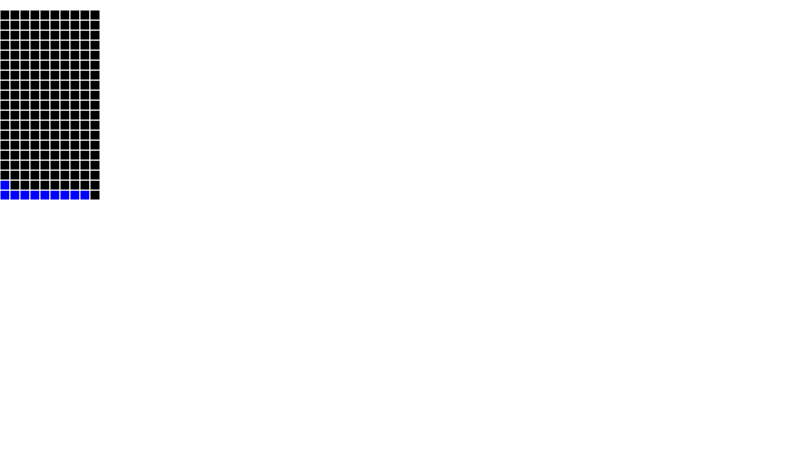

2


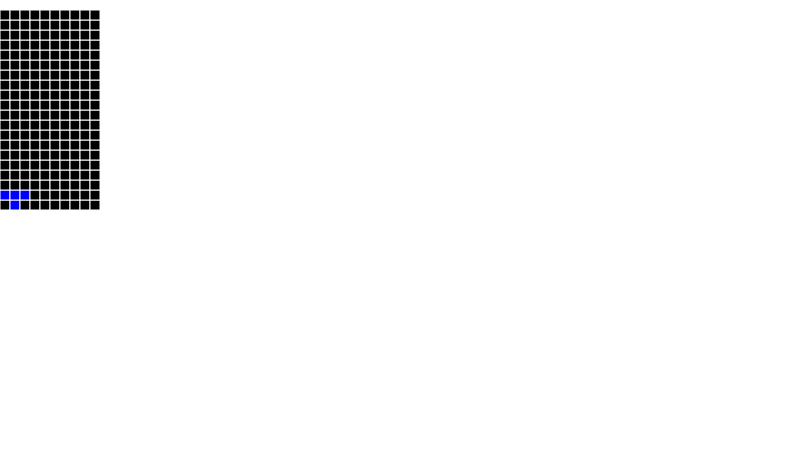

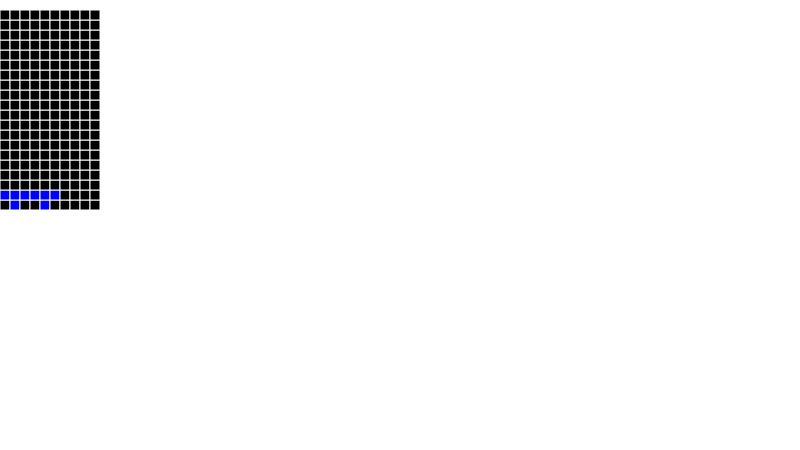

2


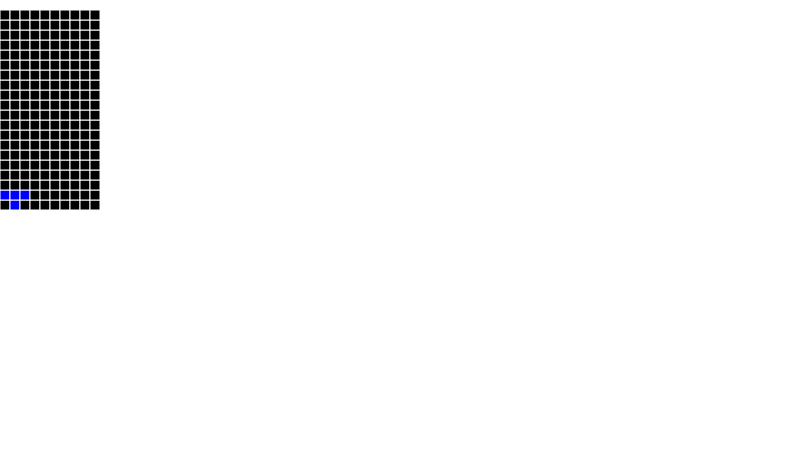

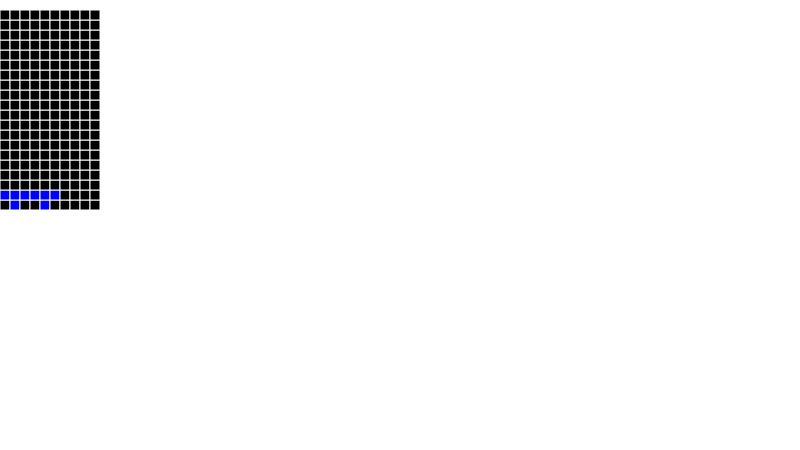

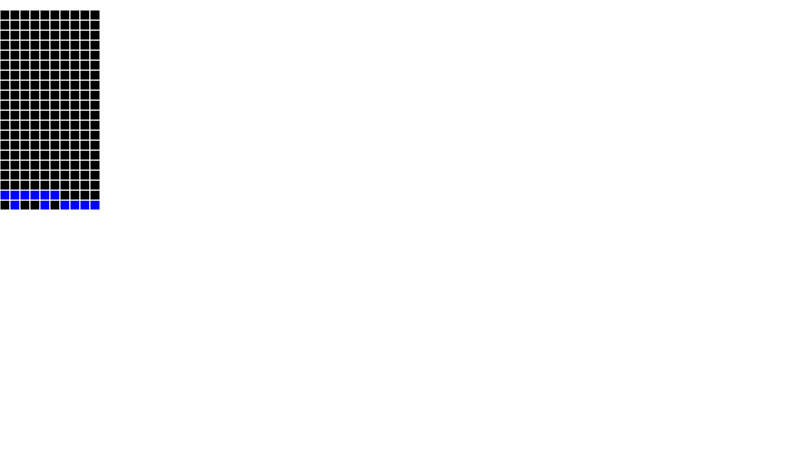

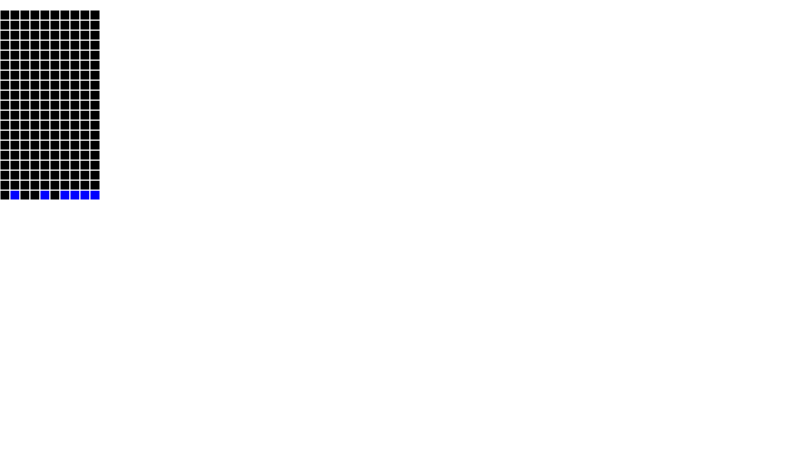

1


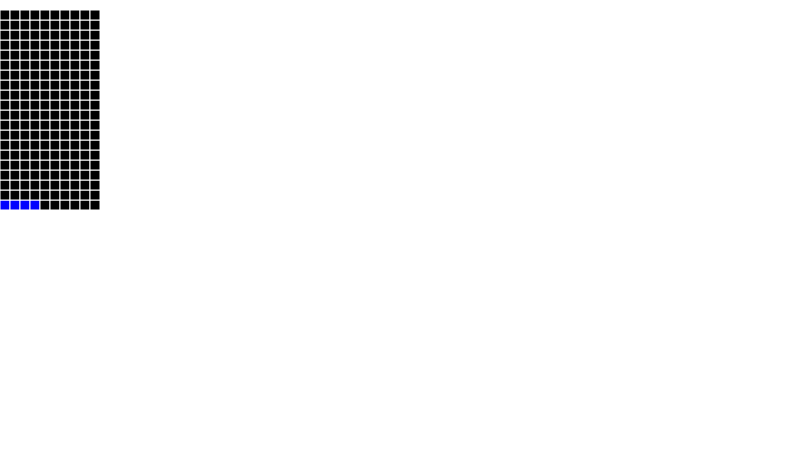

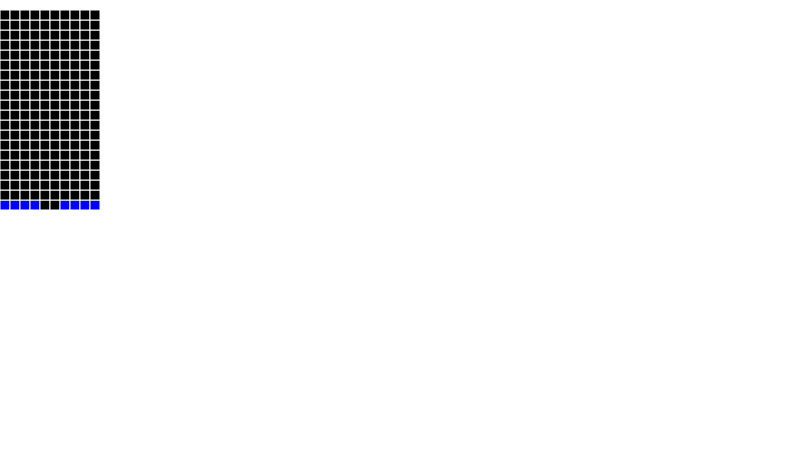

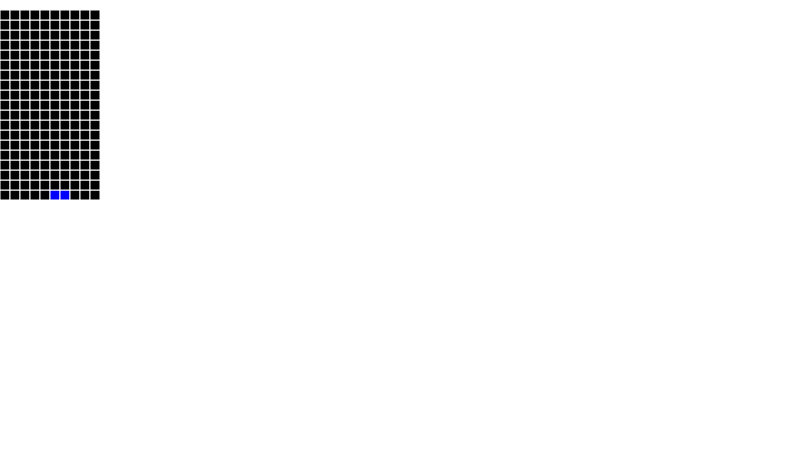

1


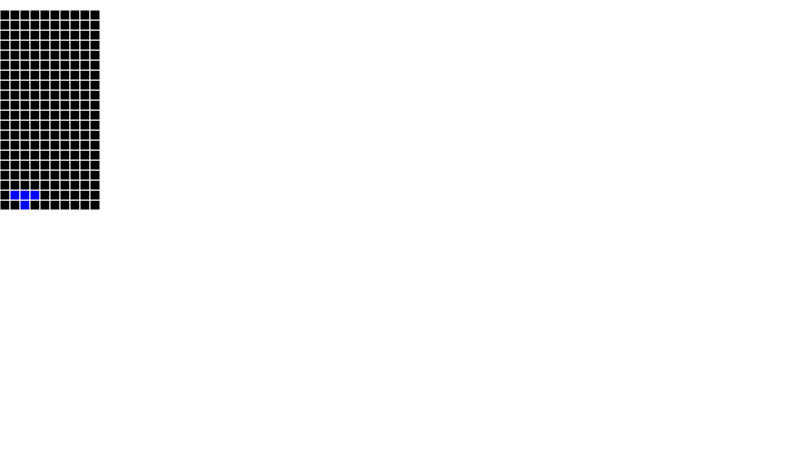

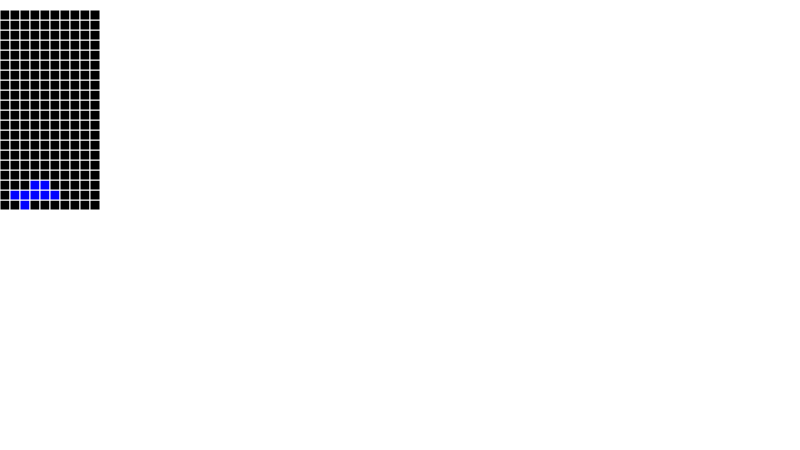

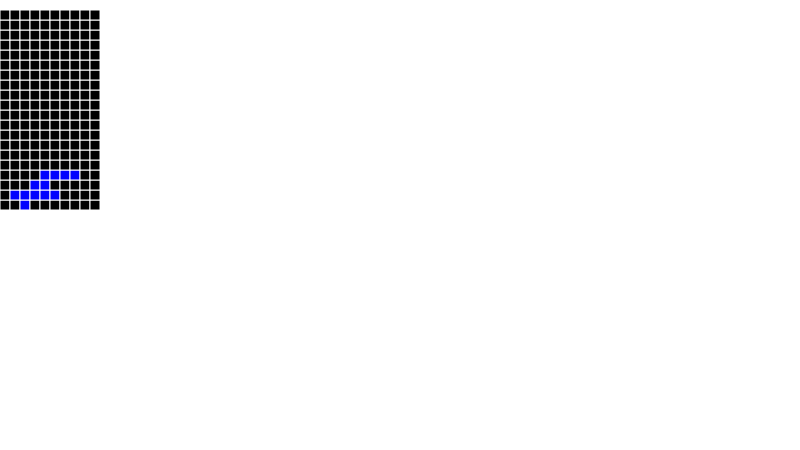

4


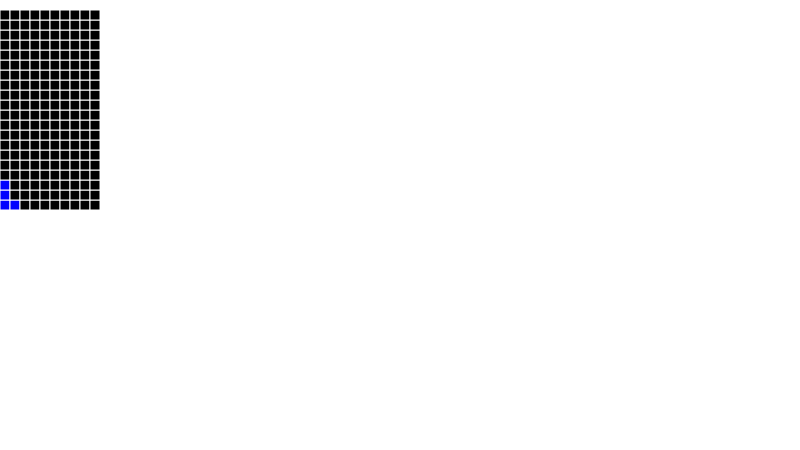

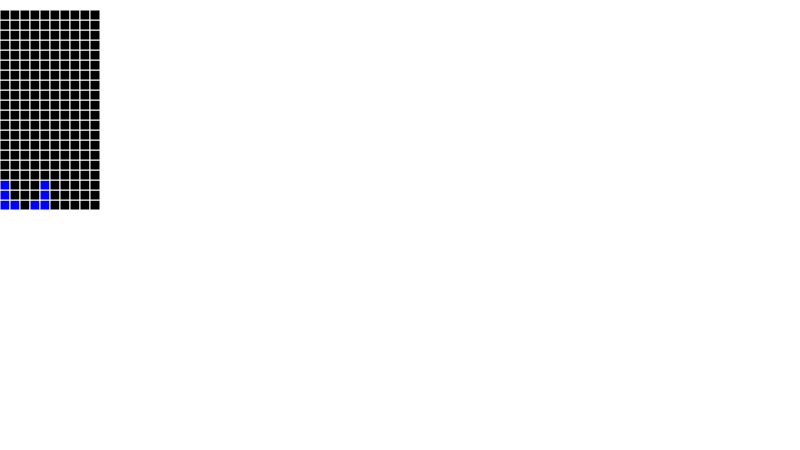

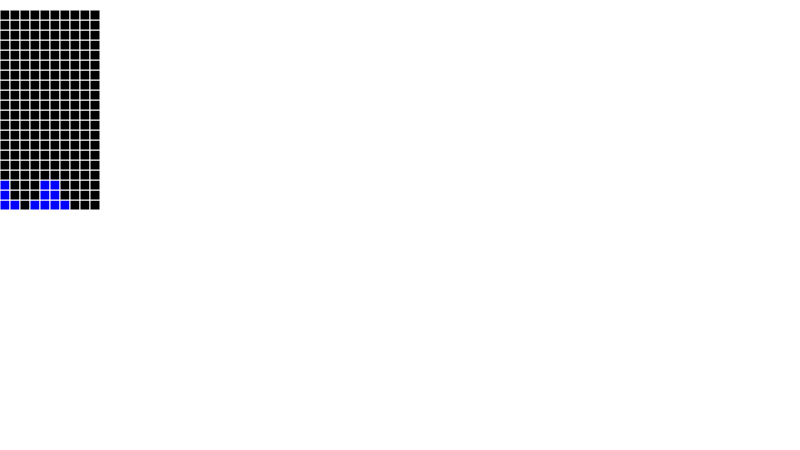

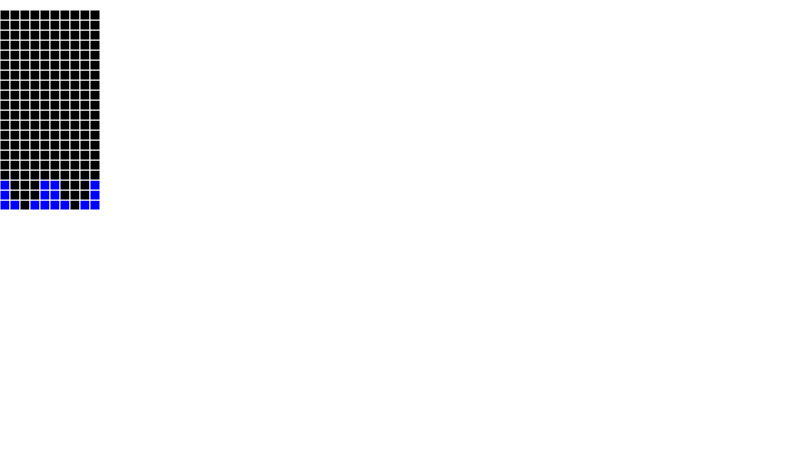

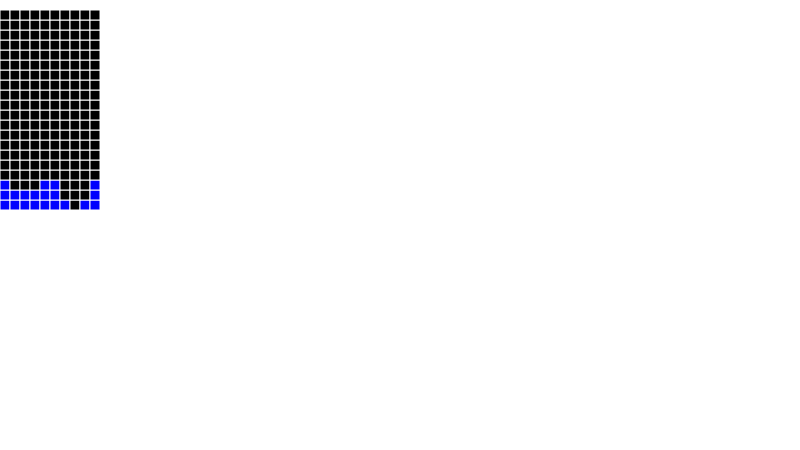

3


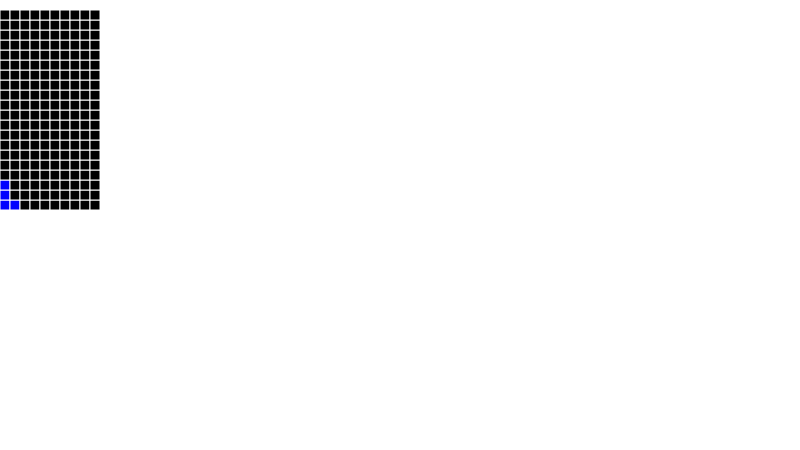

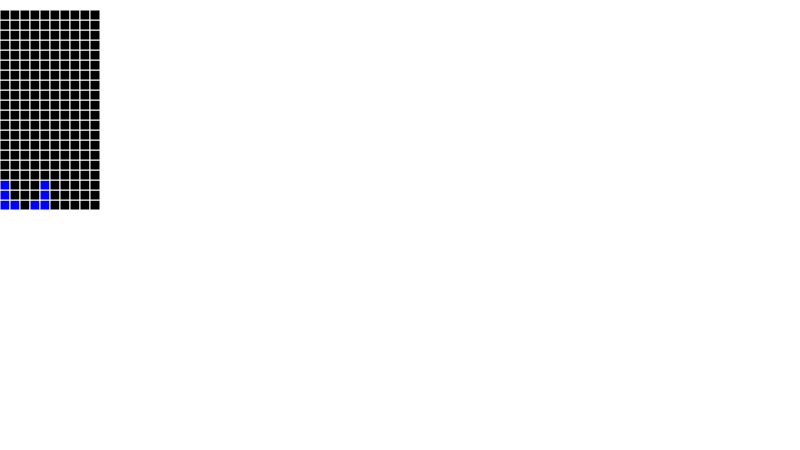

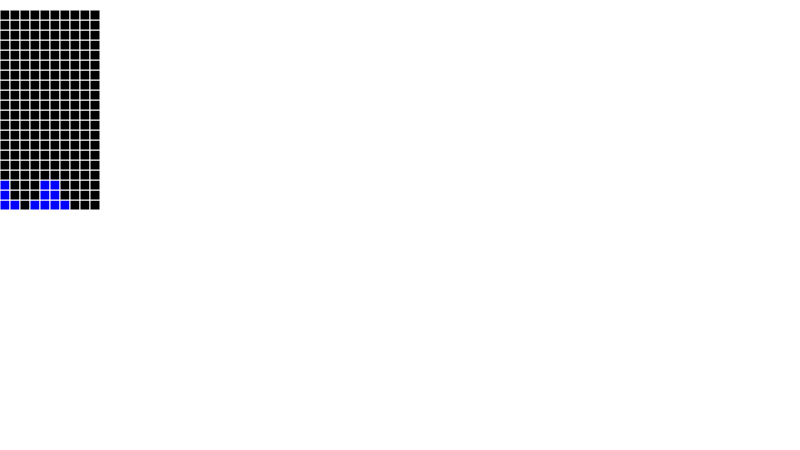

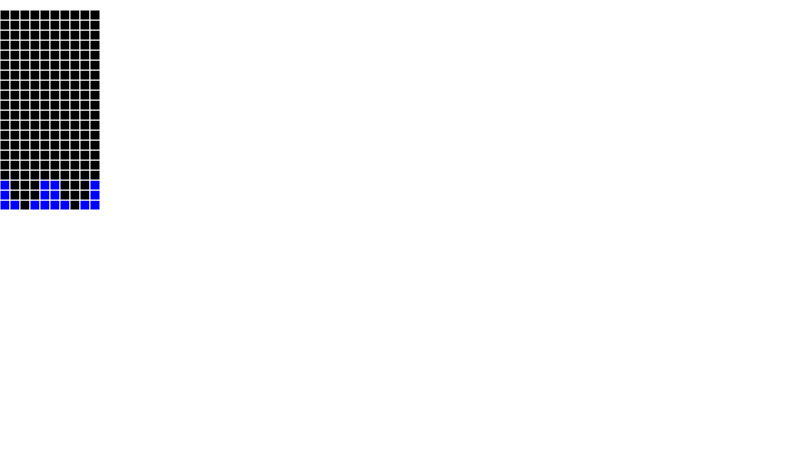

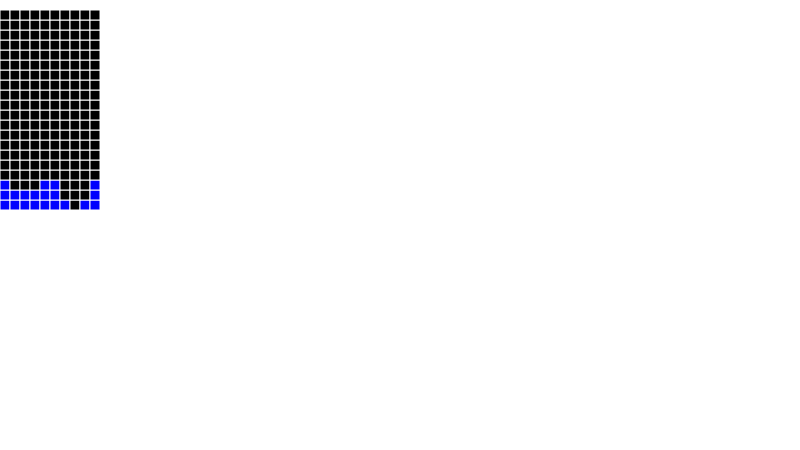

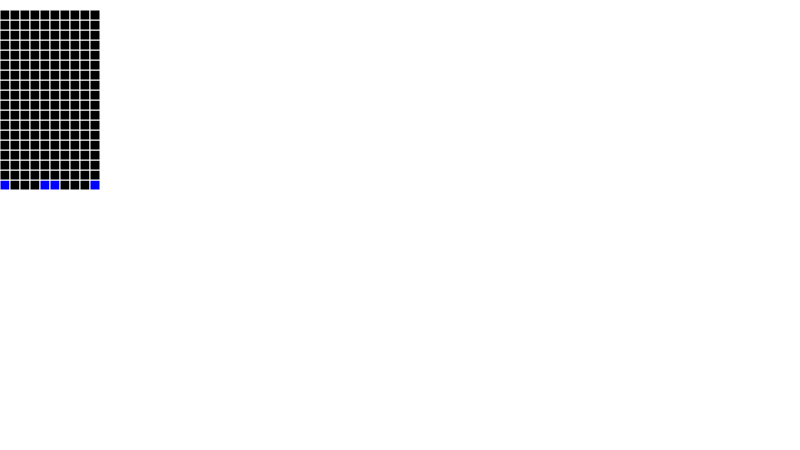

1


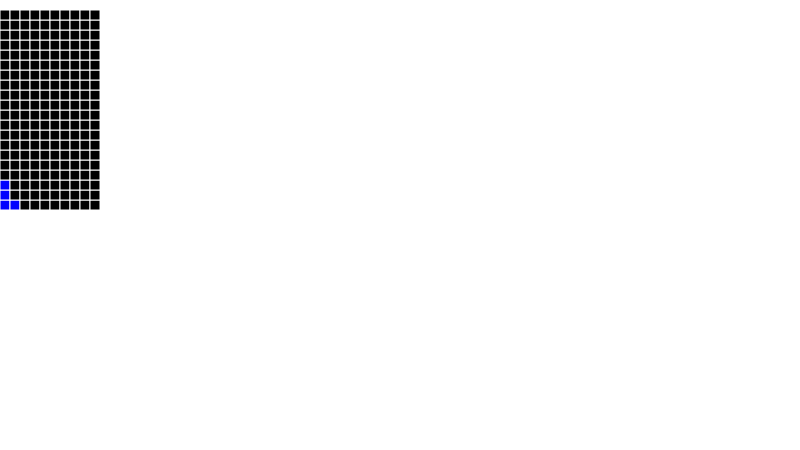

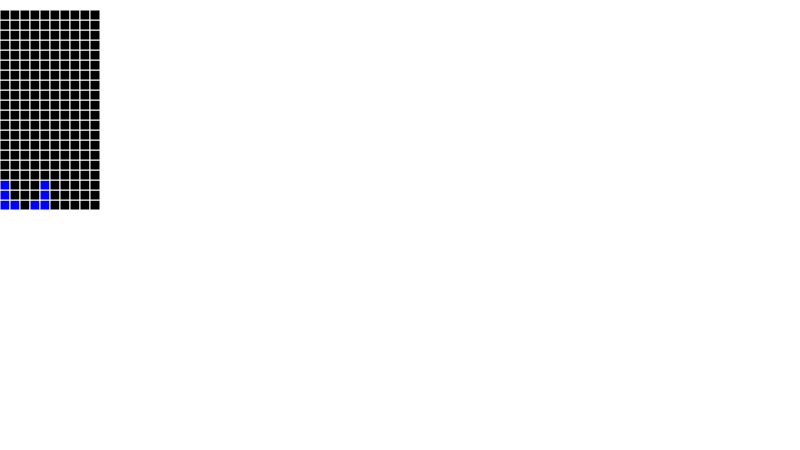

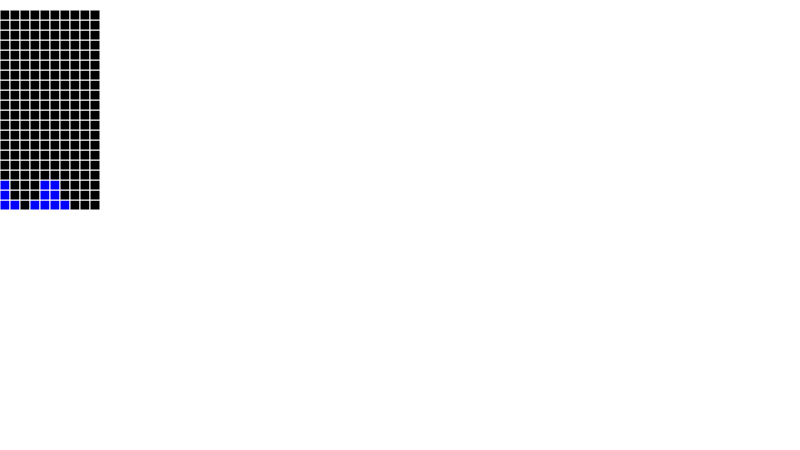

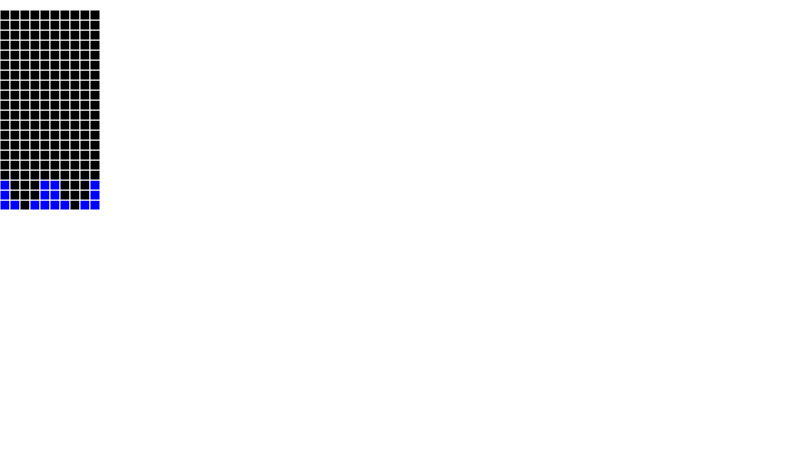

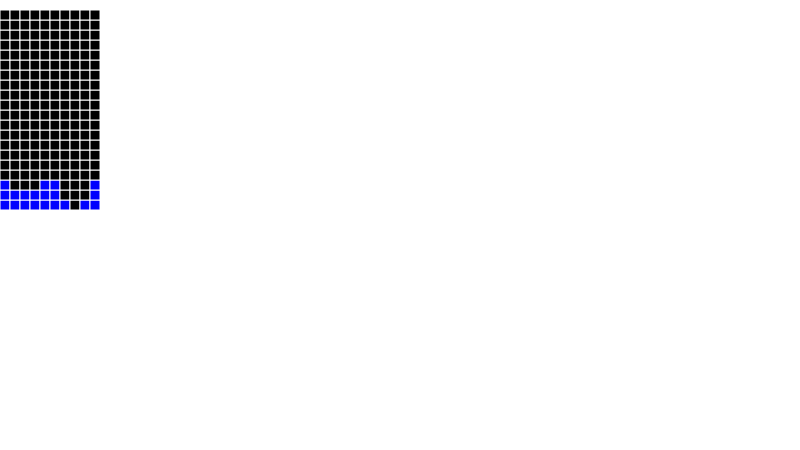

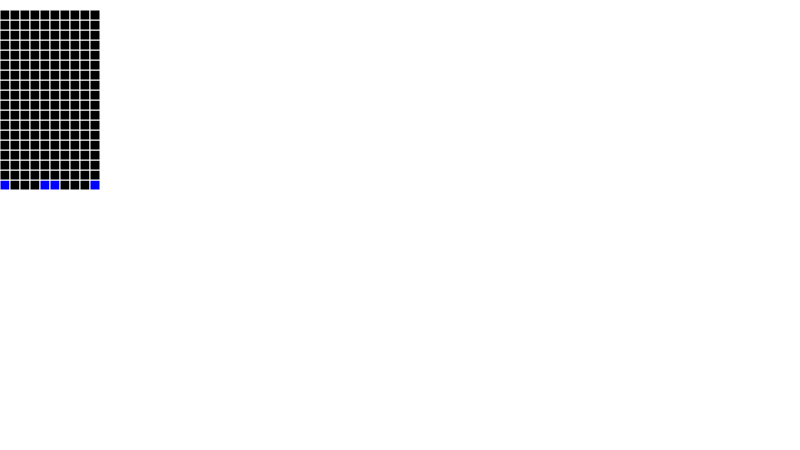

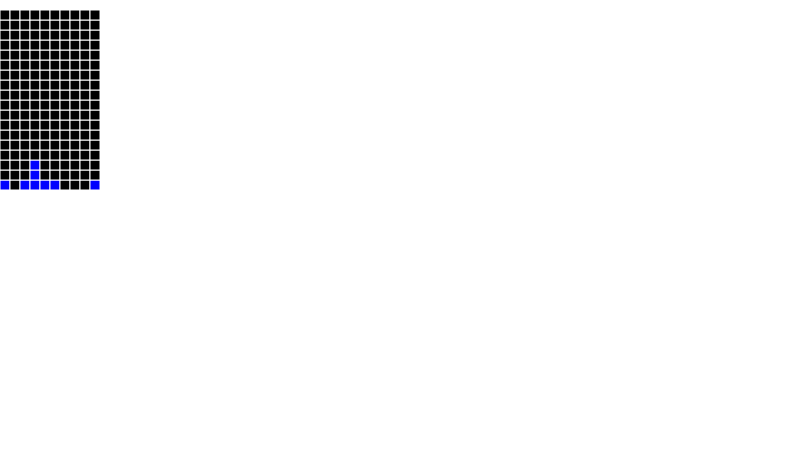

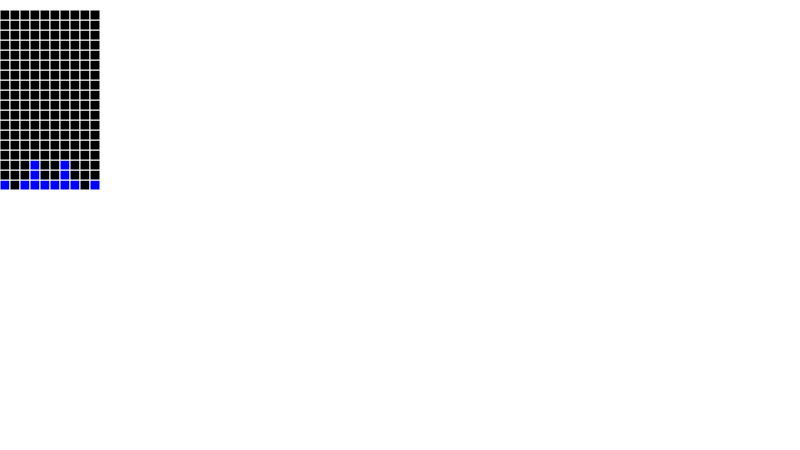

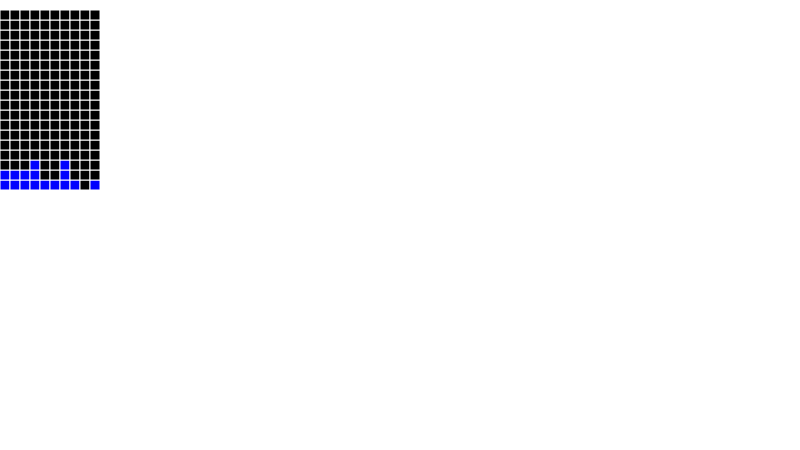

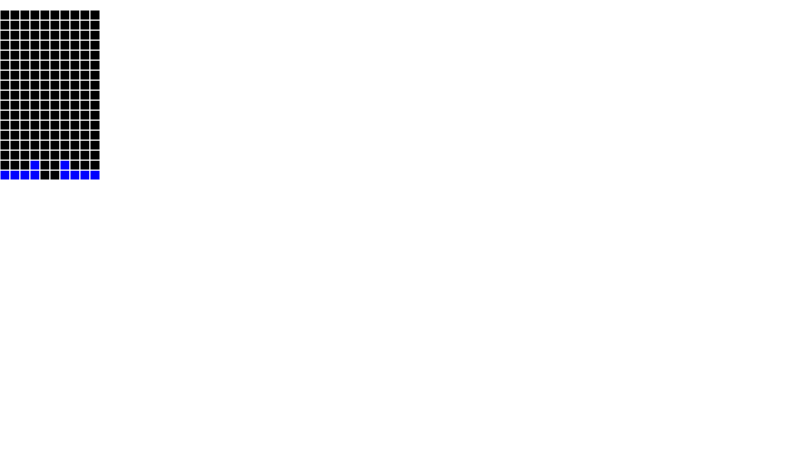

2


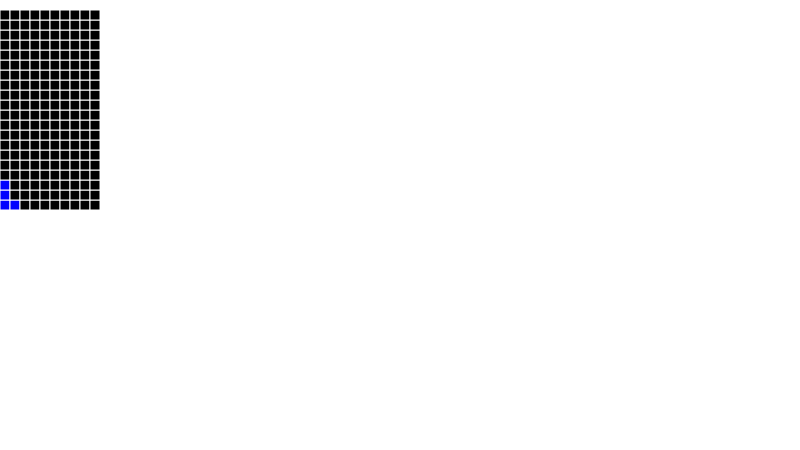

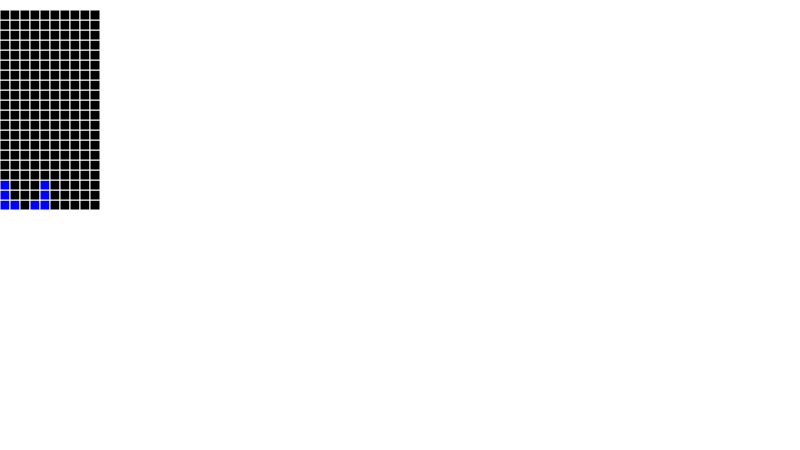

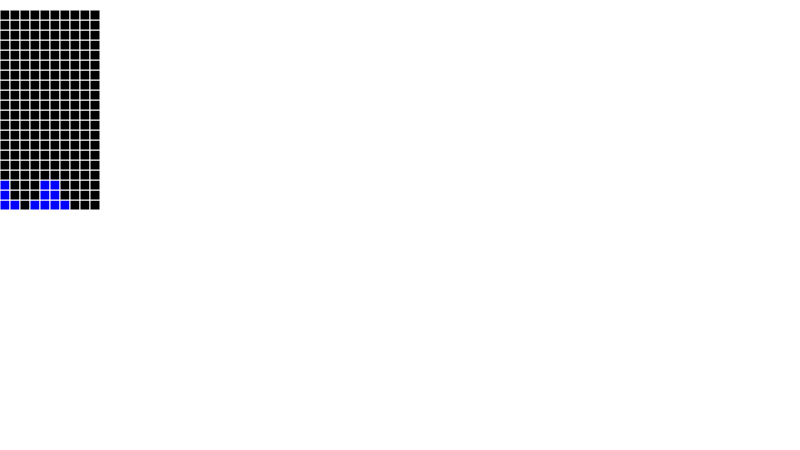

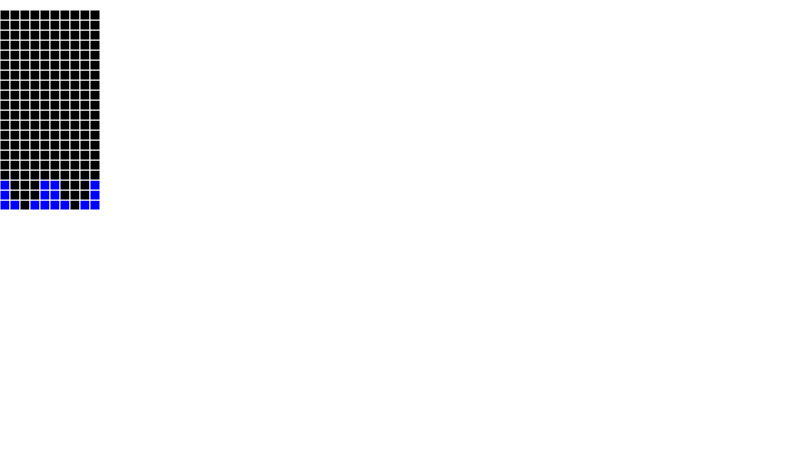

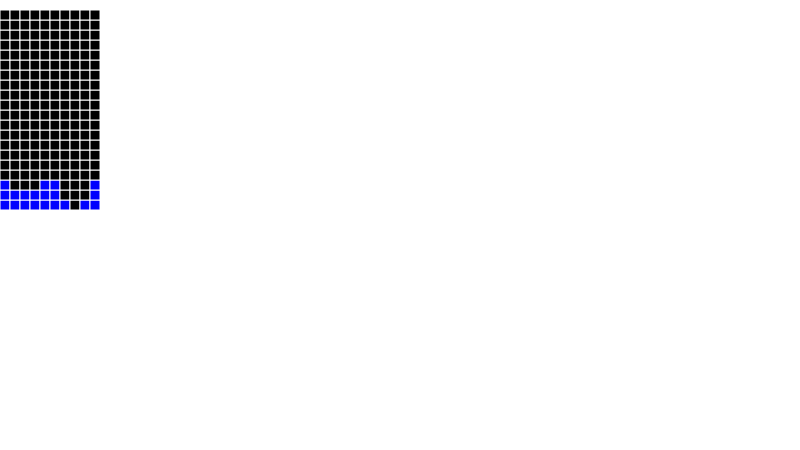

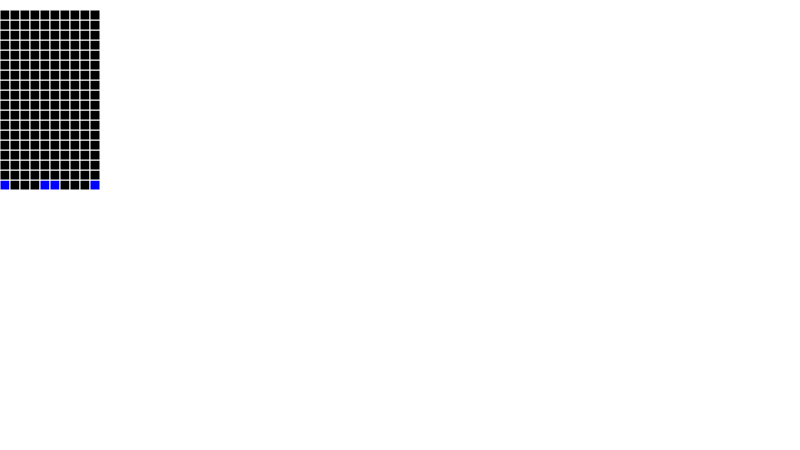

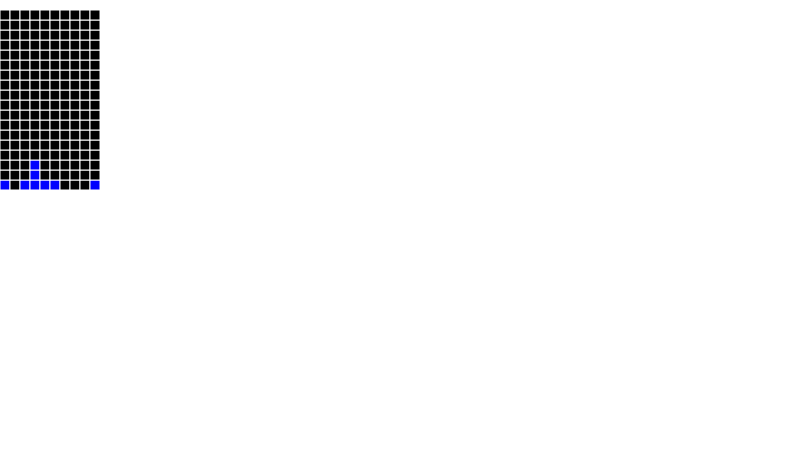

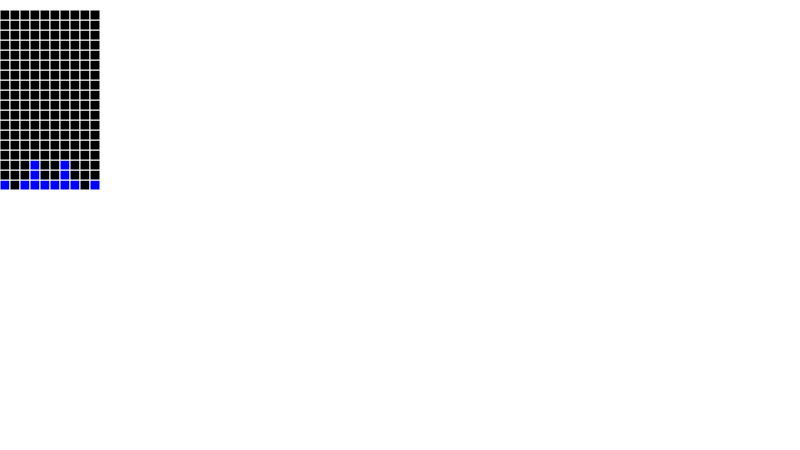

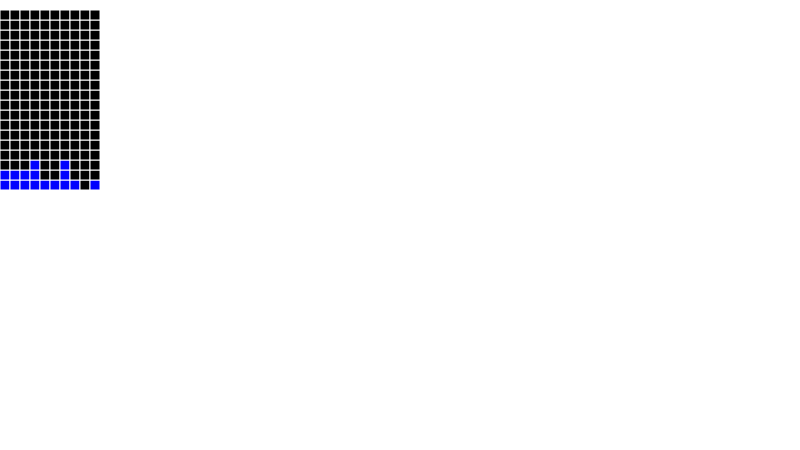

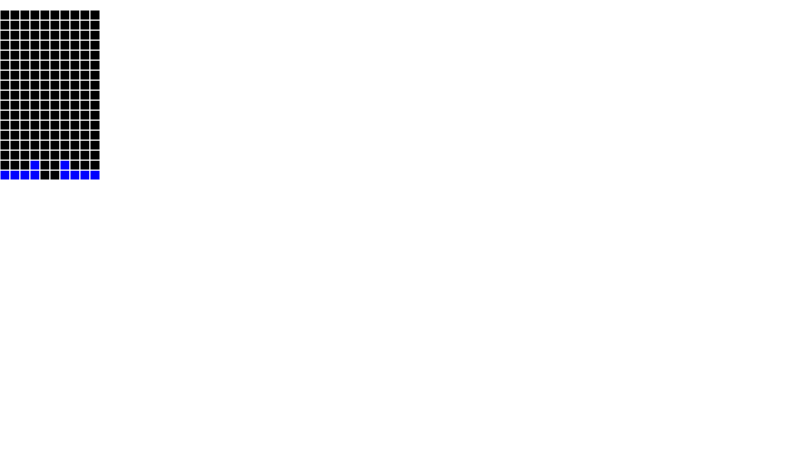

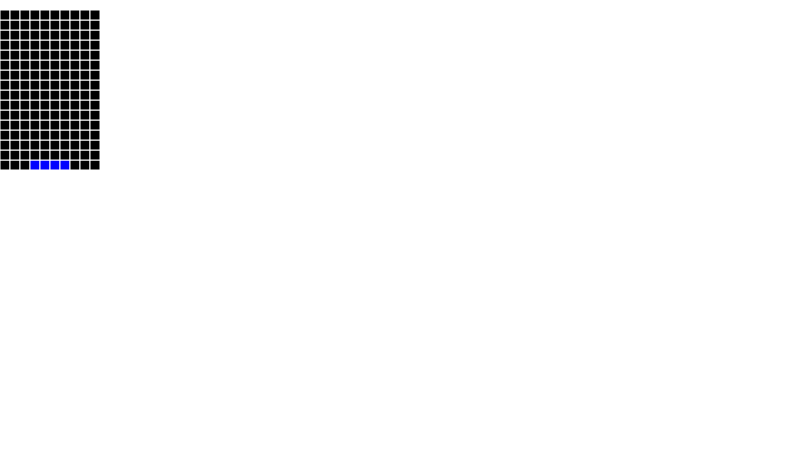

1


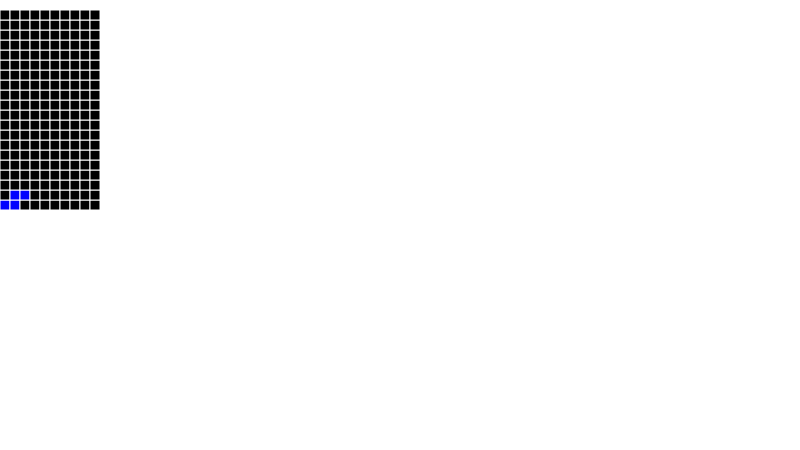

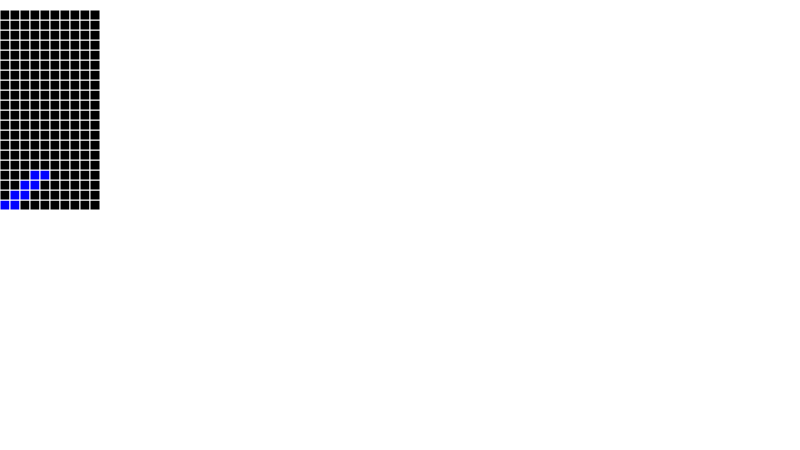

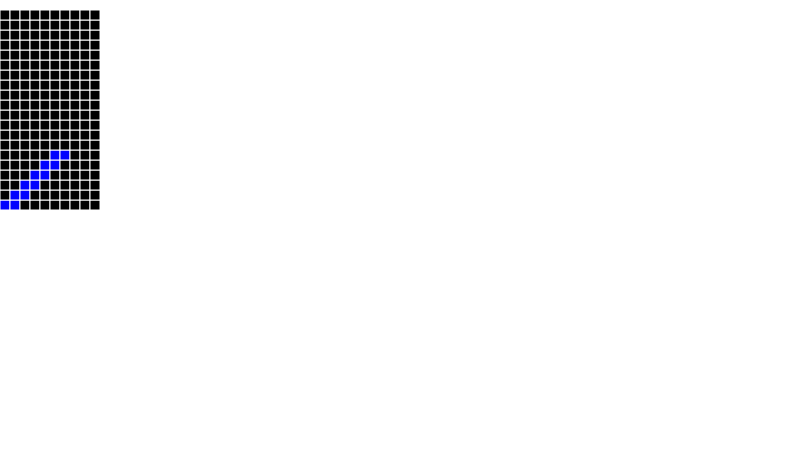

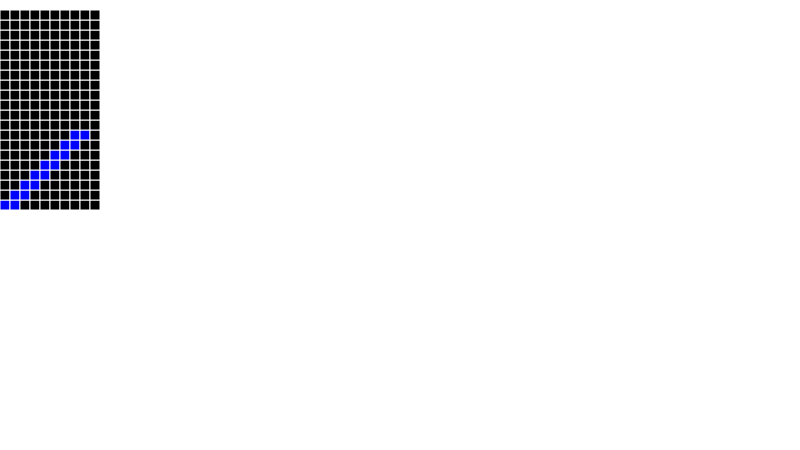

8


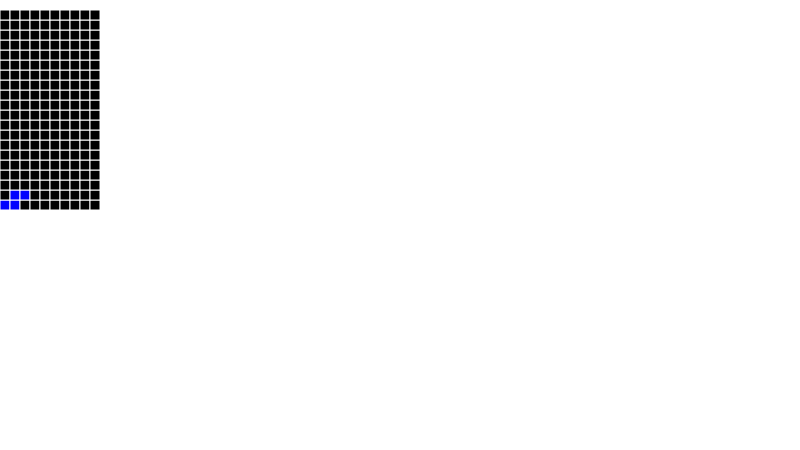

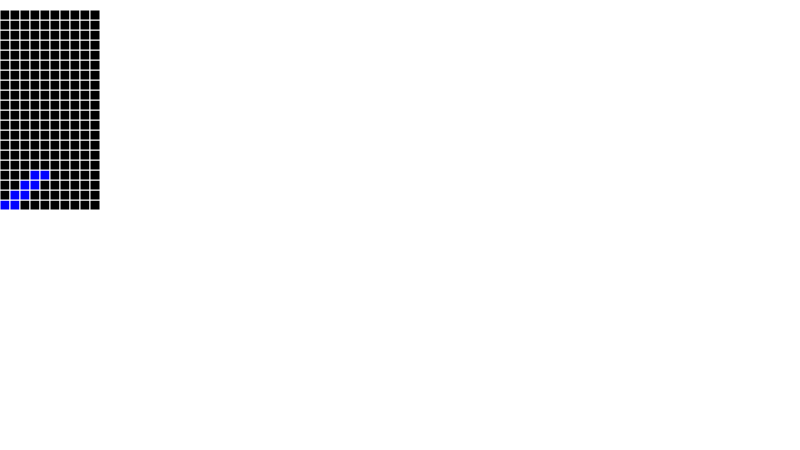

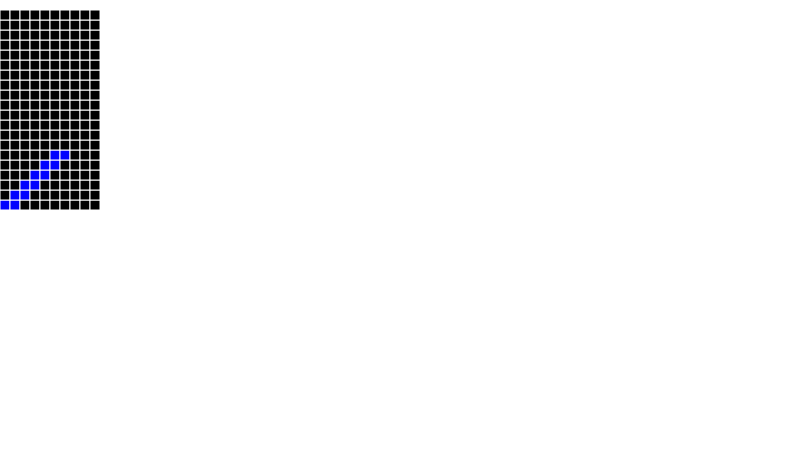

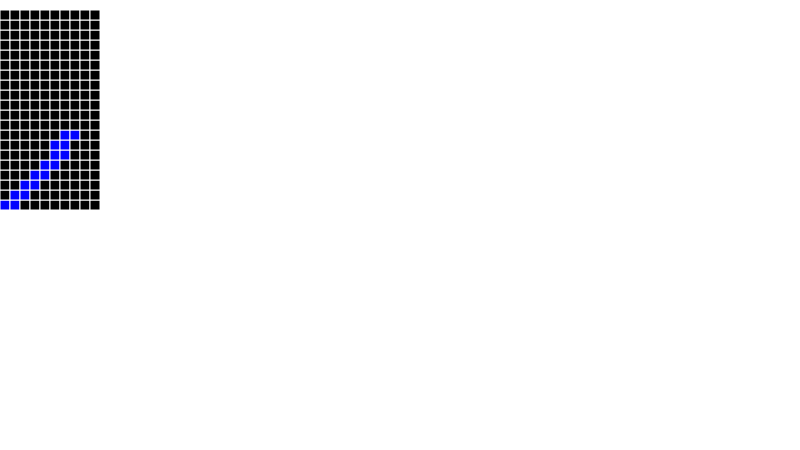

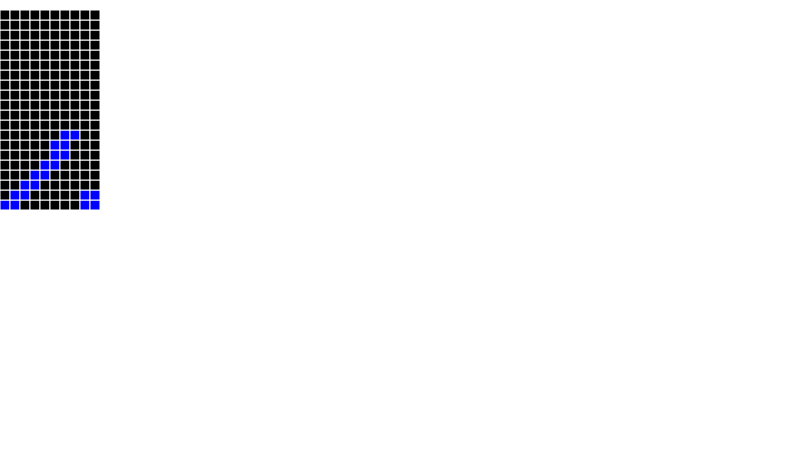

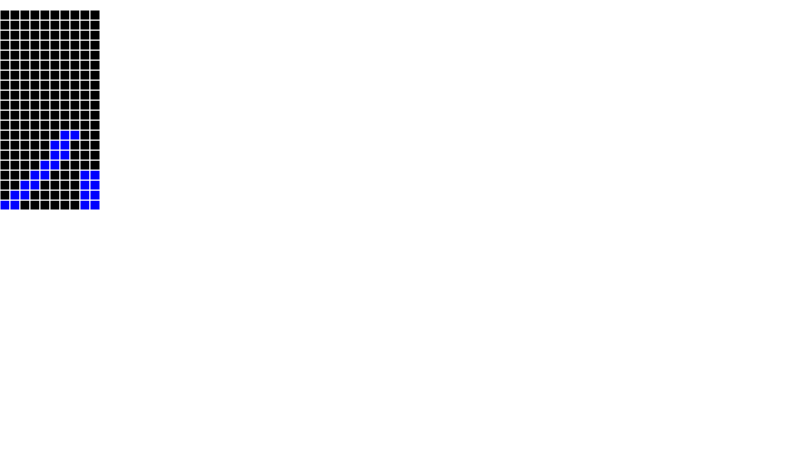

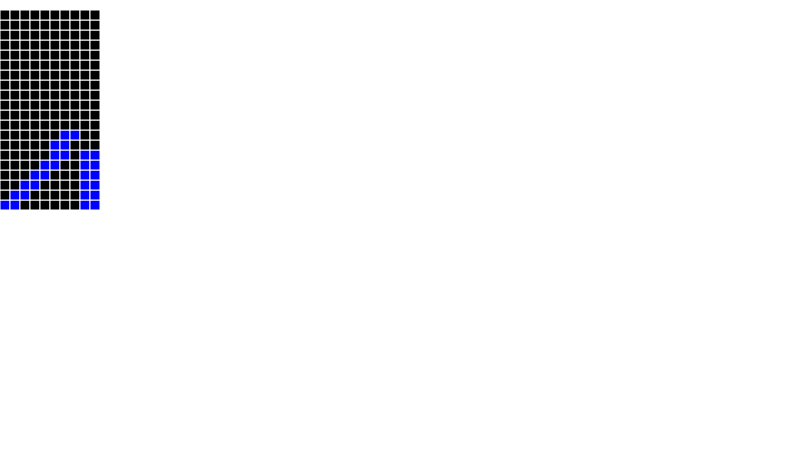

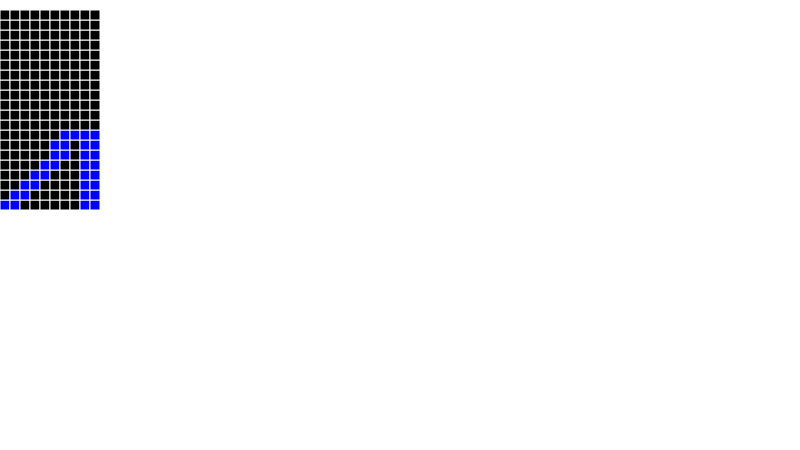

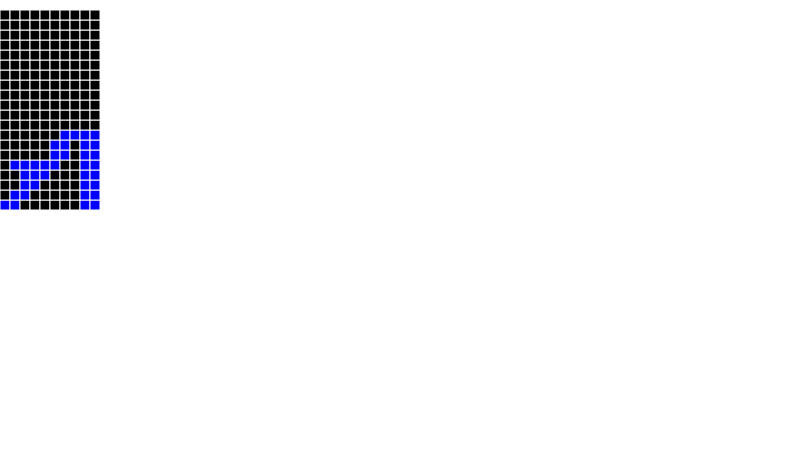

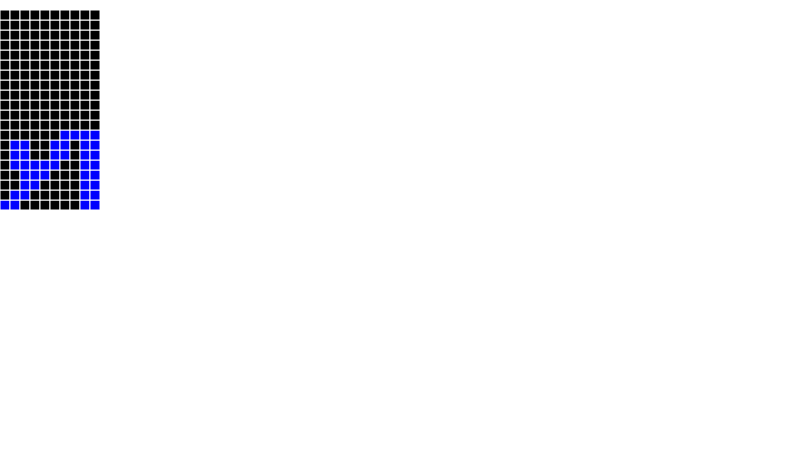

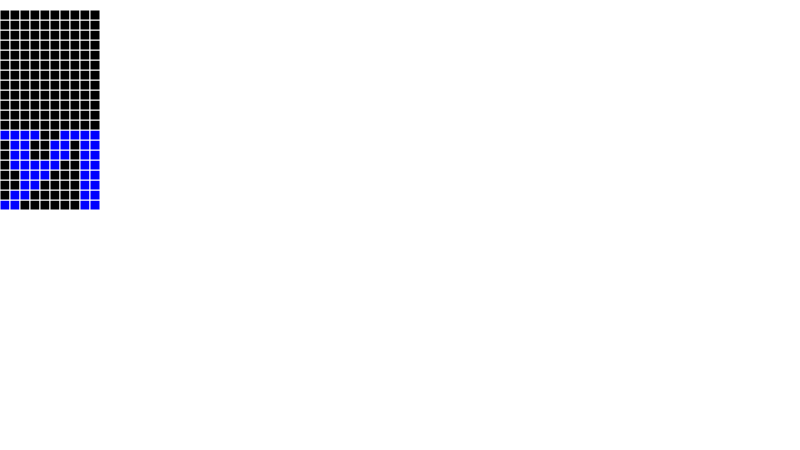

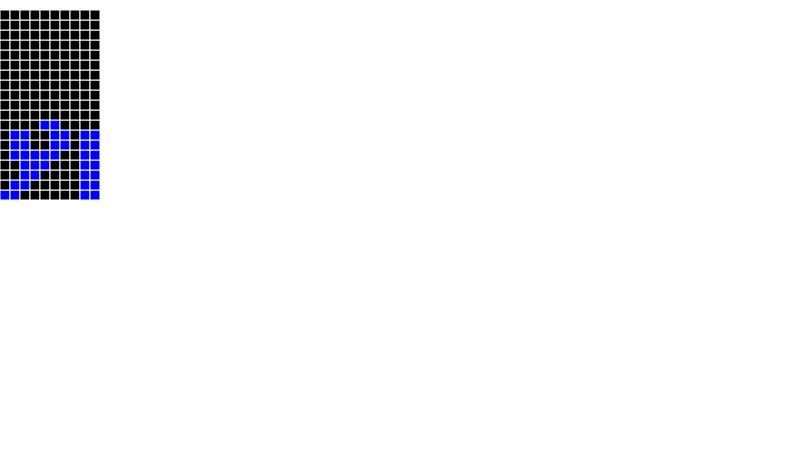

8


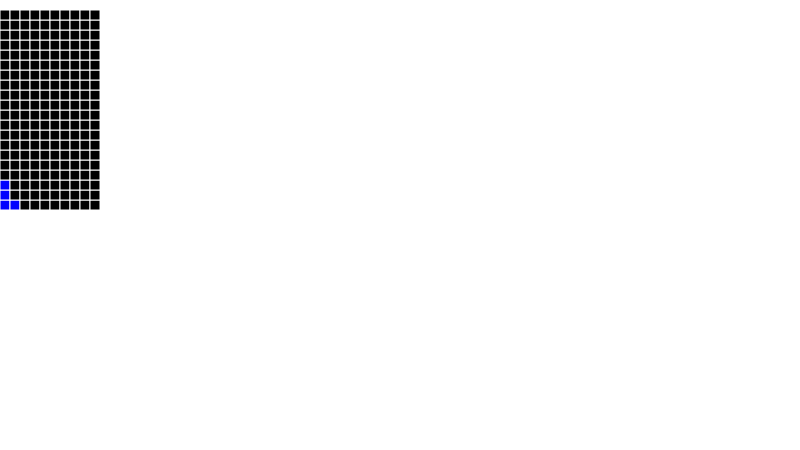

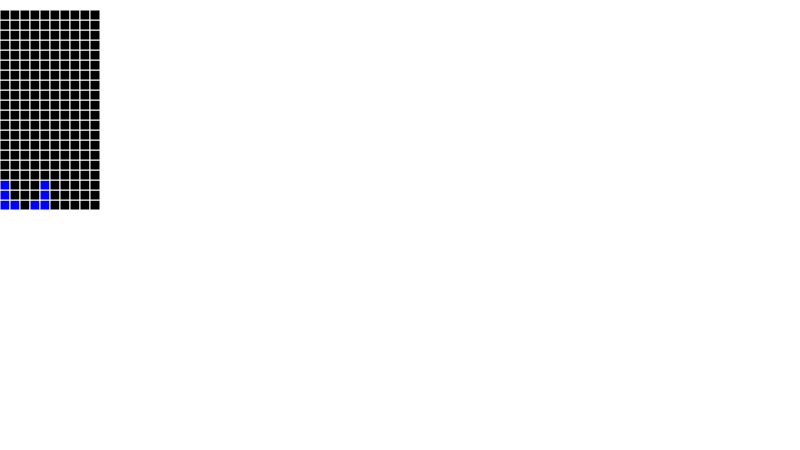

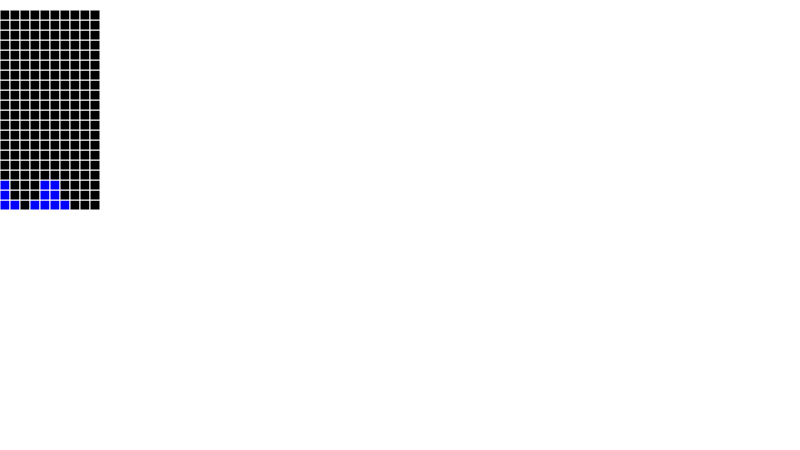

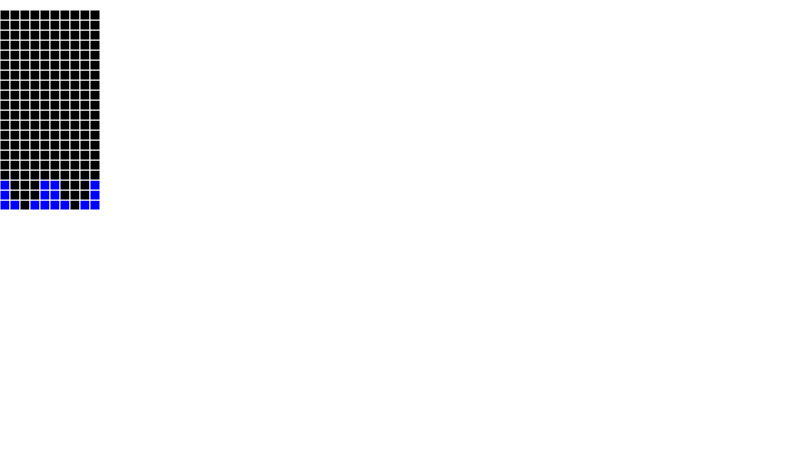

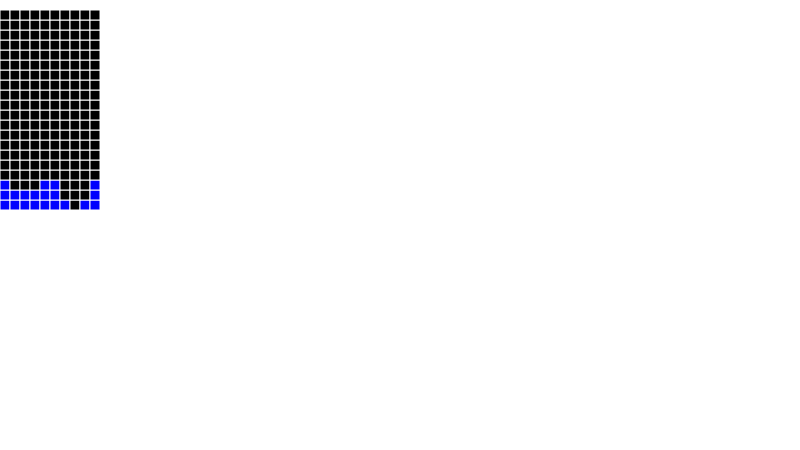

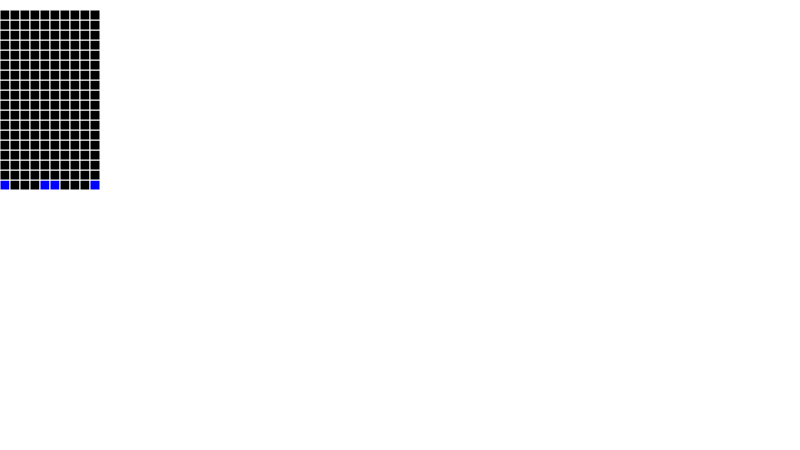

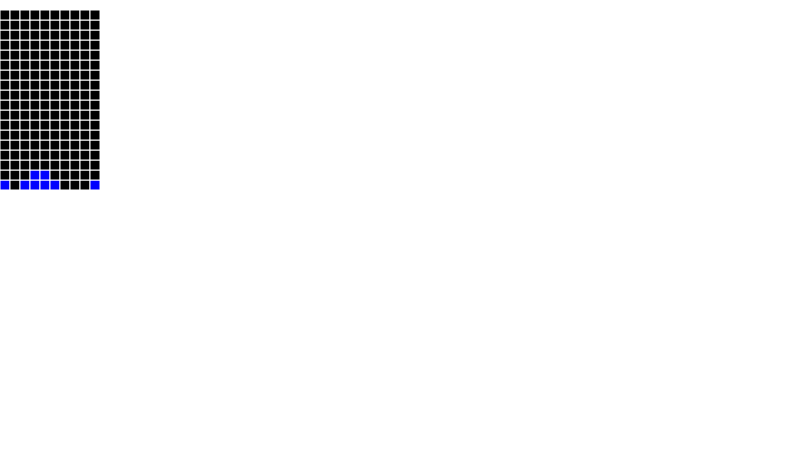

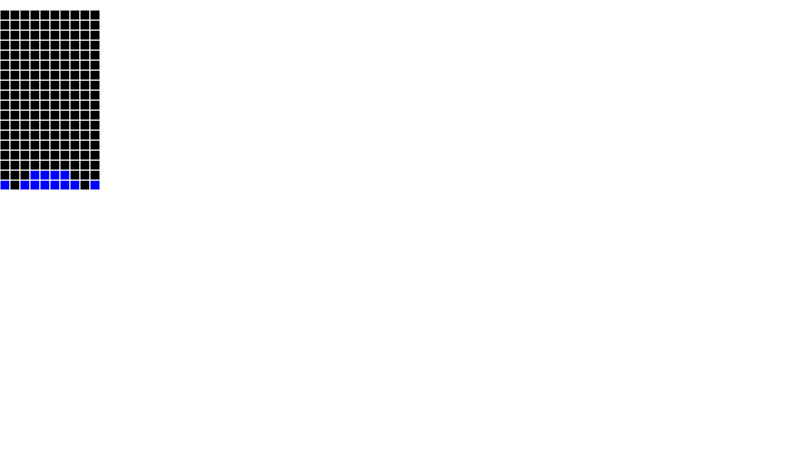

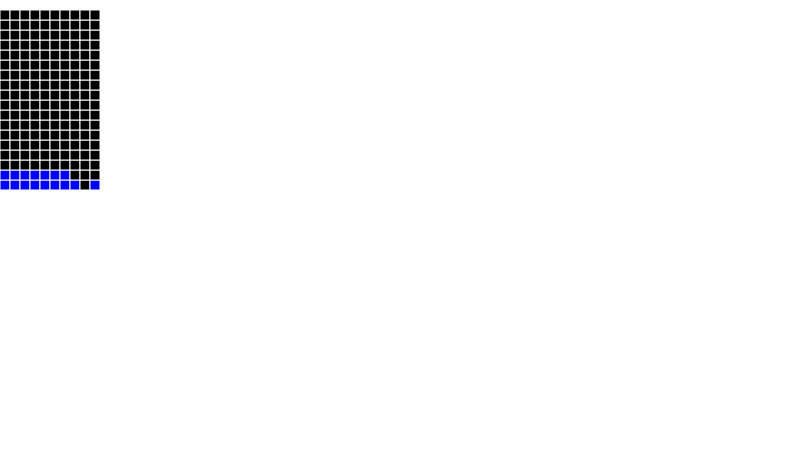

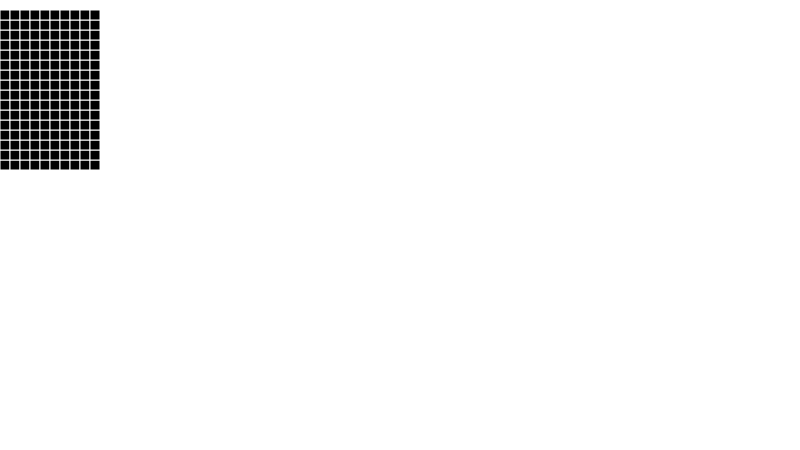

0


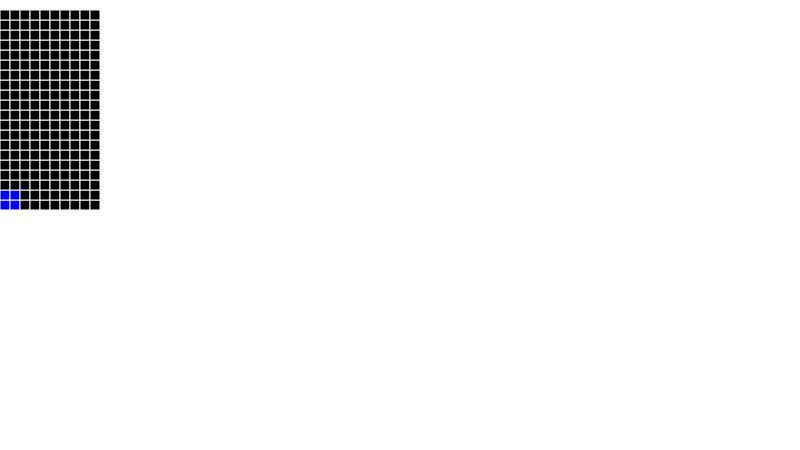

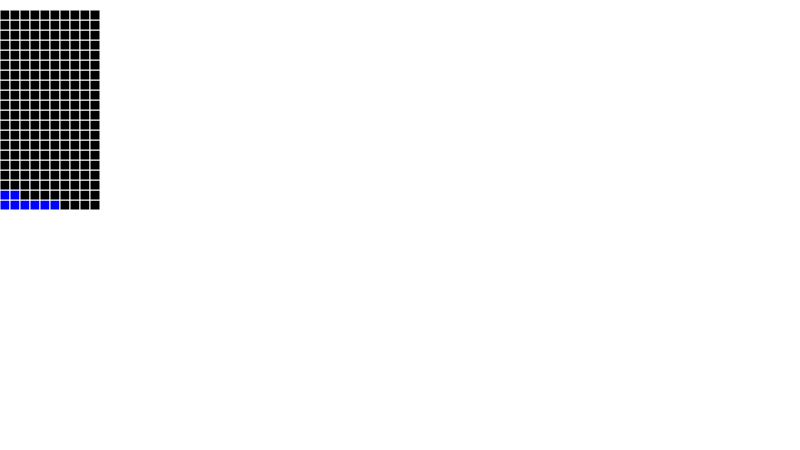

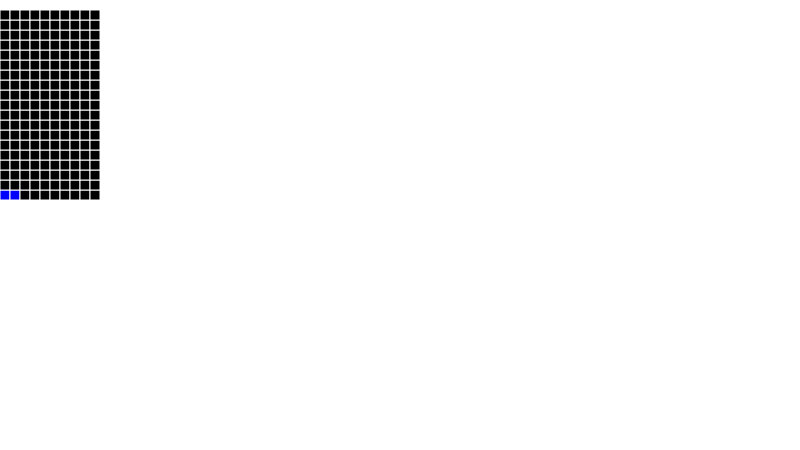

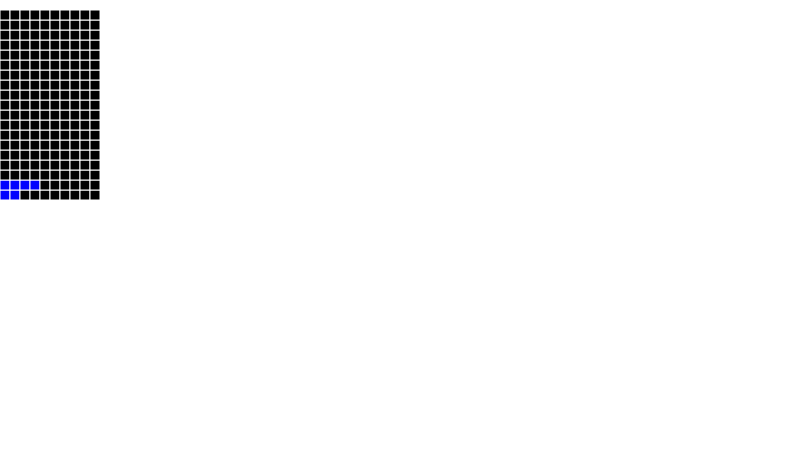

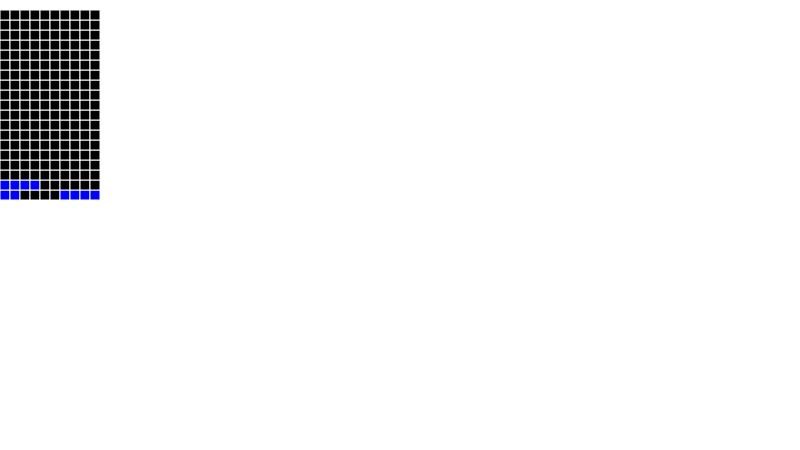

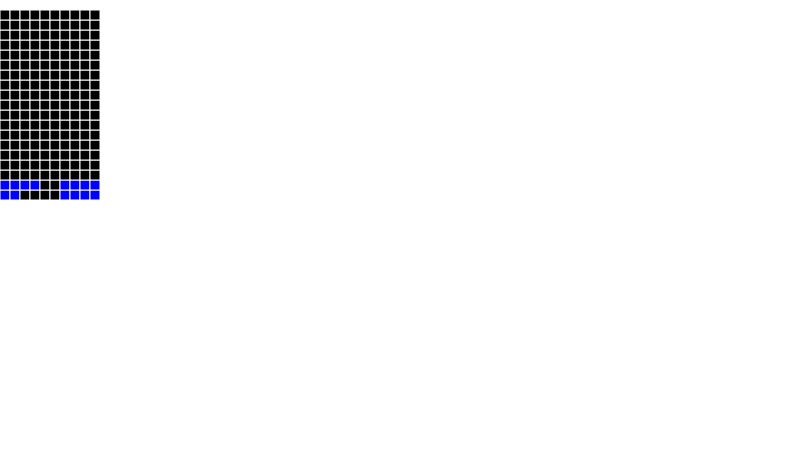

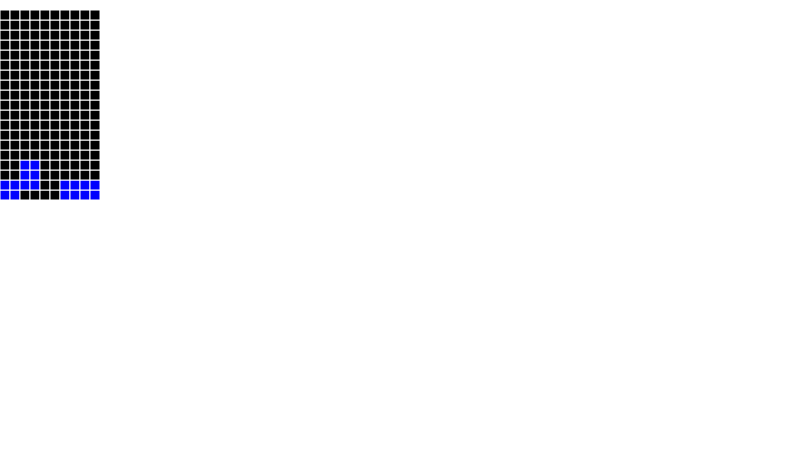

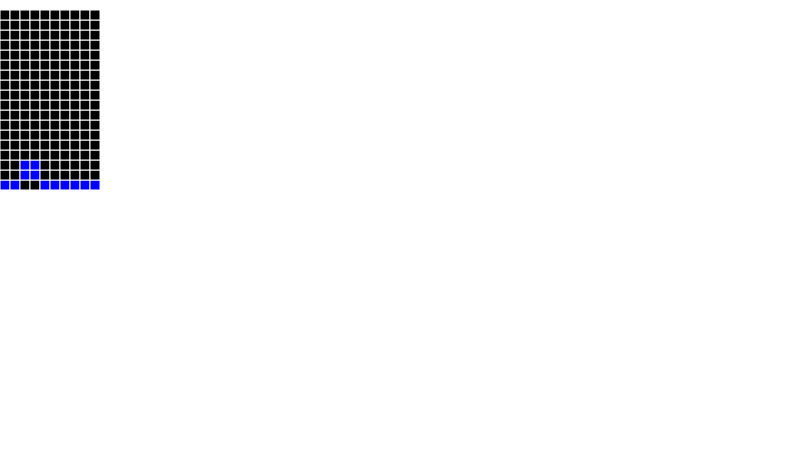

3


In [30]:
for line in open('test/input.txt'):
    pf = process(line)
    print(pf.height)

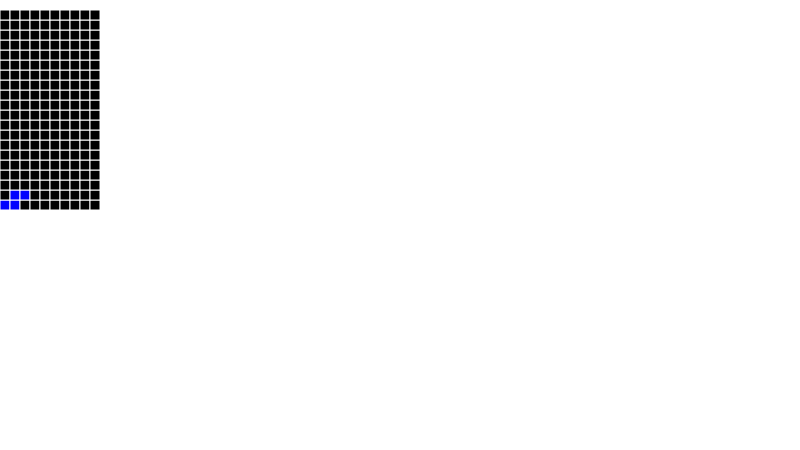

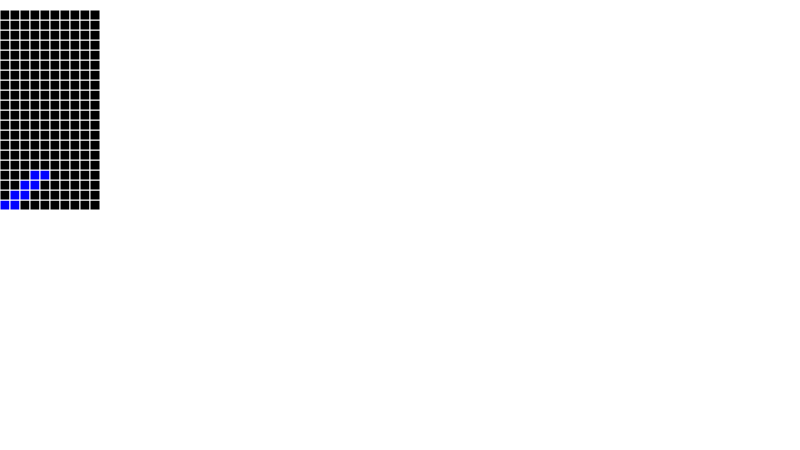

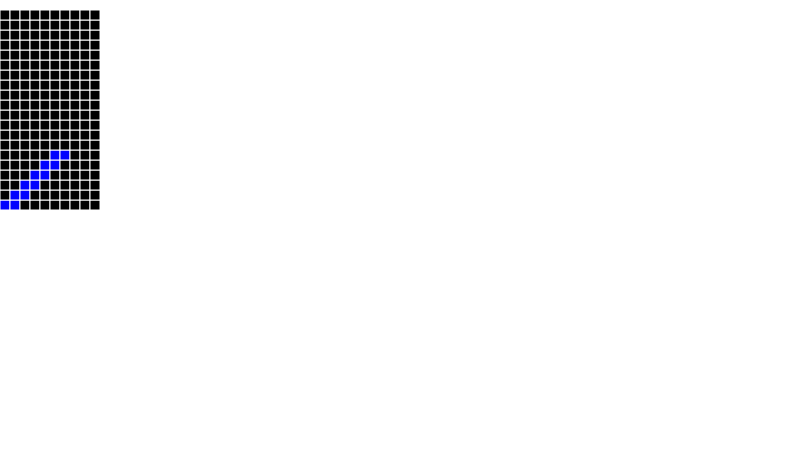

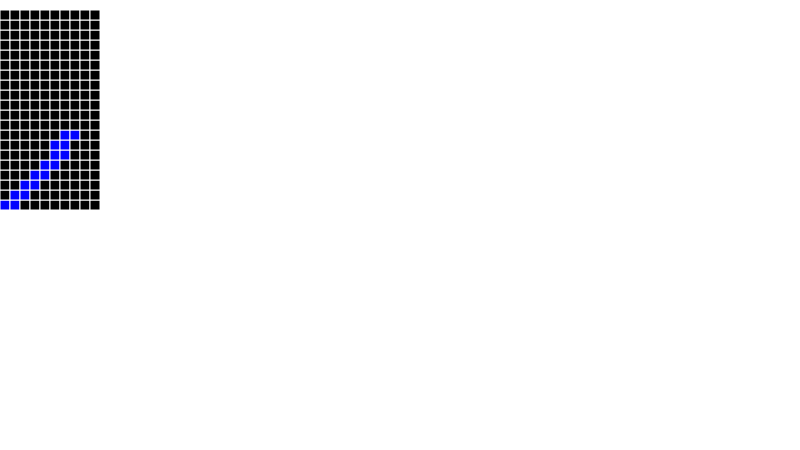

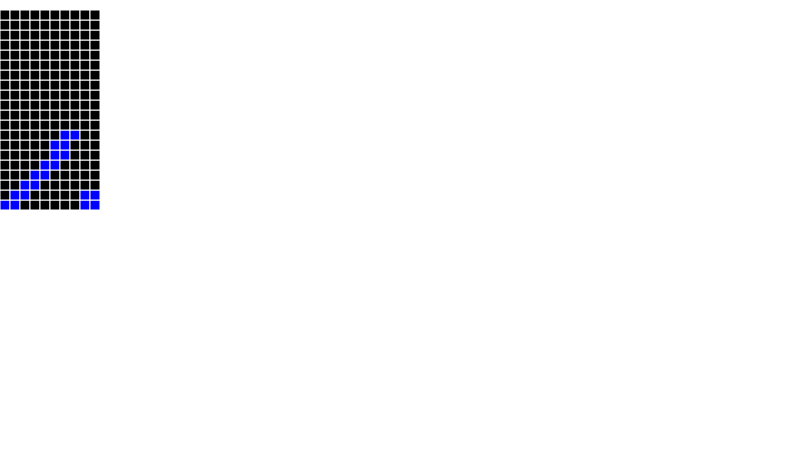

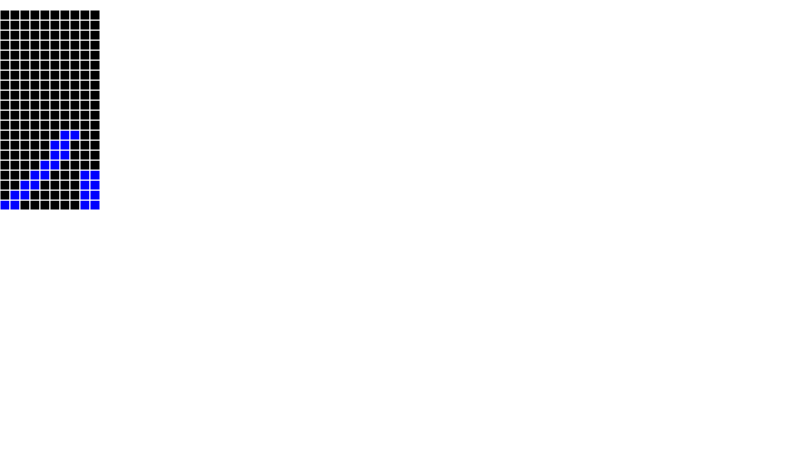

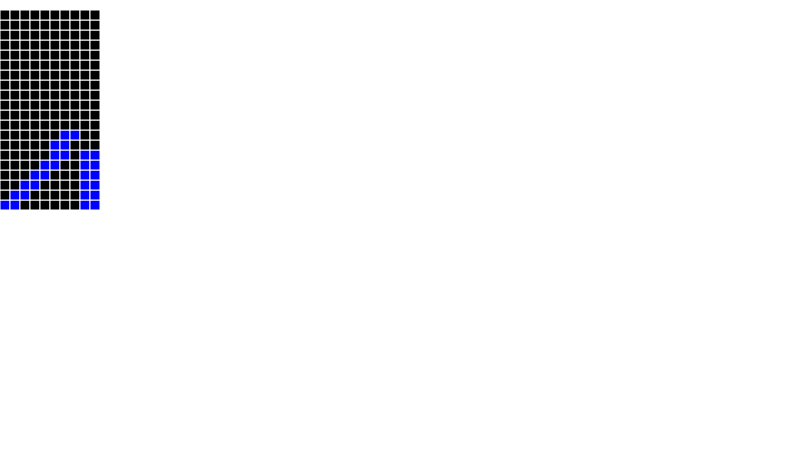

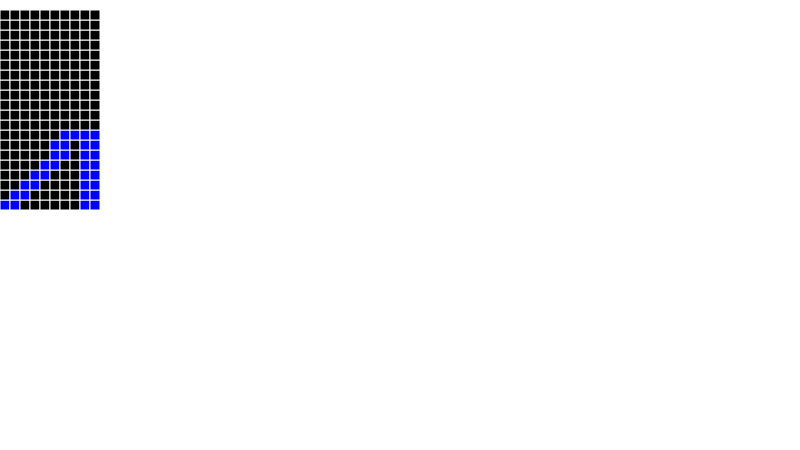

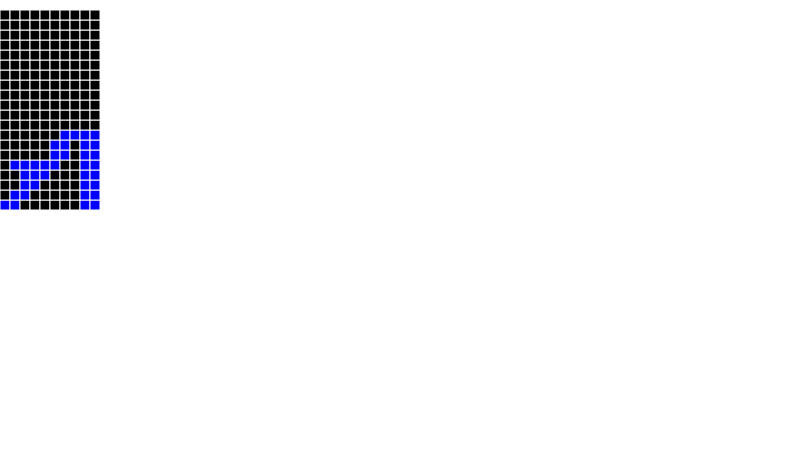

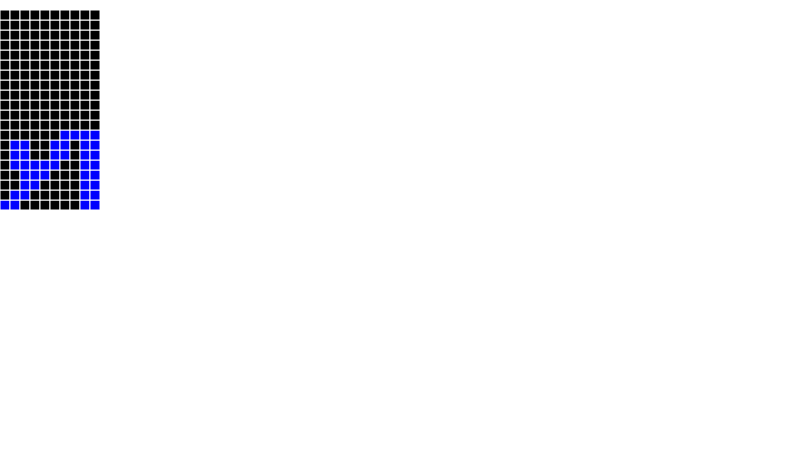

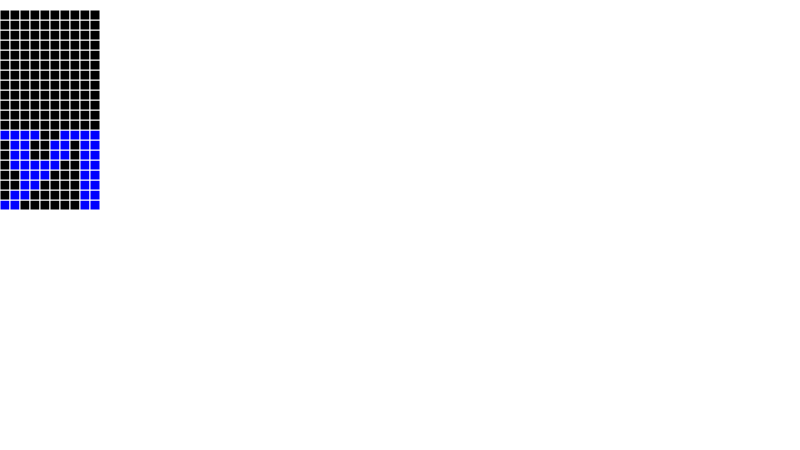

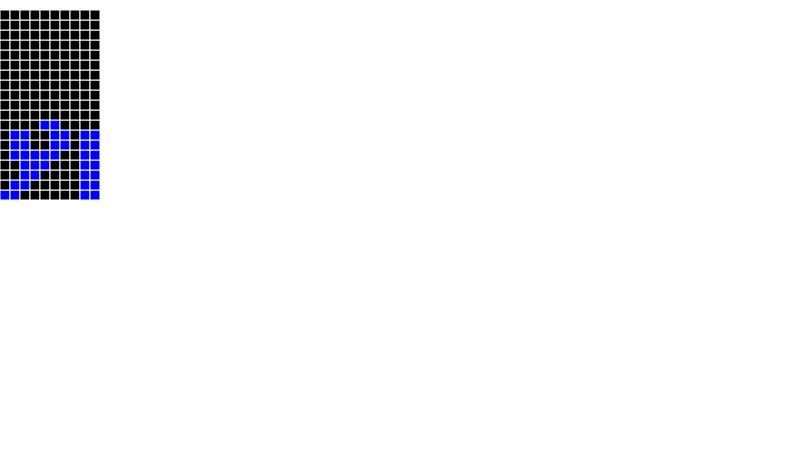

In [22]:
pf = process('S0,S2,S4,S5,Q8,Q8,Q8,Q8,T1,Q1,I0,Q4')

In [23]:
pf.height

8

In [24]:
pf.col_height

[6, 6, 6, 6, 7, 7, 6, 6, 6, 6]

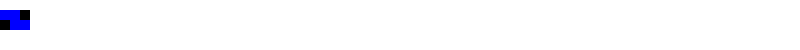

In [25]:
p = ldr.pieces['z']
p

In [26]:
p.ceil(2)

0

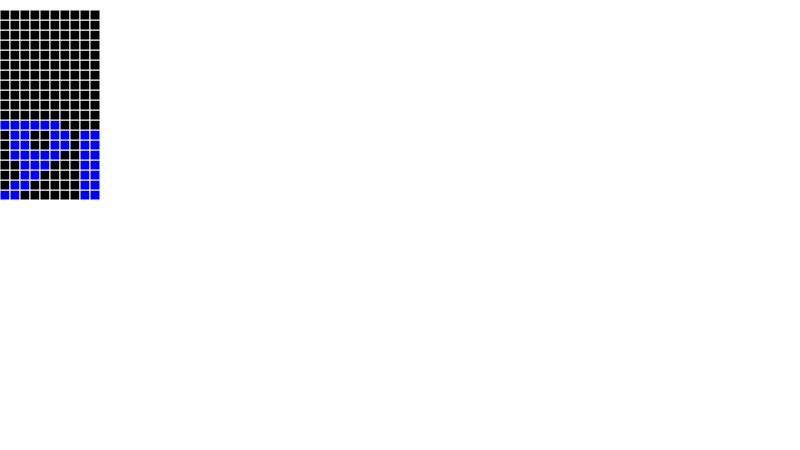

In [27]:
pf.add(Piece('****'),0)
pf

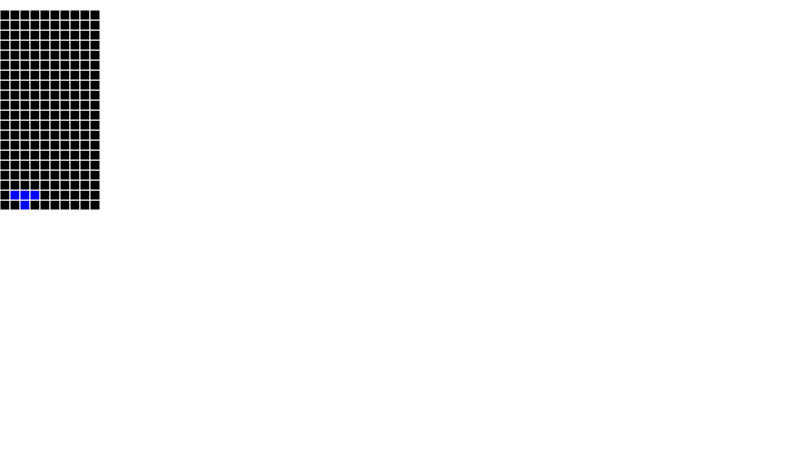

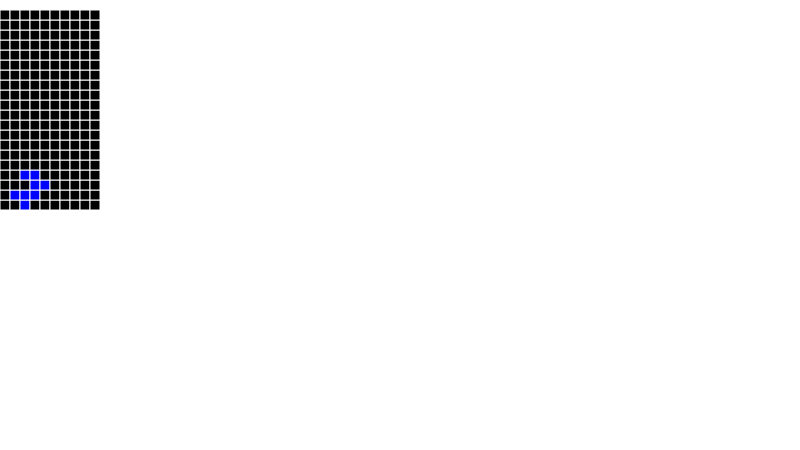

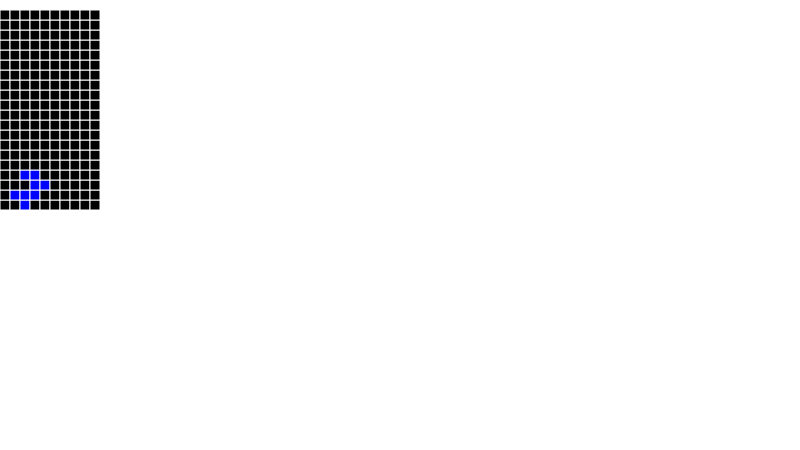

In [28]:
pf = process('T1,Z2')
pf

In [29]:
pf.col_height

[-1, 1, 3, 3, 2, -1, -1, -1, -1, -1]